In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import os
from config_images import *
import matplotlib.gridspec as gridspec

In [2]:
#save_path = "/home/labic/Projects/Alerce/datasets/simulated_data/image_sequences"
save_path = "../../datasets/simulated_data/image_sequences/good_zero_points_good_zero_points10"
f = h5py.File(save_path+".hdf5", "r")
fields = list(f.keys())
#stats = np.load("/home/toshiba/rodrigo/simulated_lightcurves/multiclass_SNLS_short20000.pkl")

In [3]:
list(f.keys()) # ['Field01', 'Field02', 'Field03', 'Field04' ...]
list(f["Field01"].keys())
"""['count_lightcurves',
 'galaxy_flag',
 'galaxy_image',
 'ids',
 'images',
 'labels',
 'lc_type',
 'lightcurves',
 'obs_cond',
 'psf_image']"""
data_keys = ['count_lightcurves',
 'galaxy_flag',
 'galaxy_image',
 'ids',
 'images',
 'labels',
 'lc_type',
 'lightcurves',
 'obs_cond',
 'psf_image']
list(f["Field01"]["images"].keys())

['g', 'r']

In [4]:
list(f["Field01"]['obs_cond'].keys())

['airmass',
 'epoch',
 'exp_time',
 'filter',
 'flux_conversion',
 'good_quality_points',
 'limmag3',
 'limmag5',
 'obs_day',
 'seeing',
 'sky_brightness',
 'zero_point']

In [5]:
#f["Field01"]['lightcurves']['g'][0]

In [6]:
f["Field01"]['estimated_counts']['g']

<HDF5 dataset "g": shape (60, 11), type "<f8">

In [7]:
def print_shape(f, data_keys, n_fields = 5, bands = ["g", "r"]):
    fields = list(f.keys())
    for field in fields[:n_fields]:
        print("Field", field)
        #data_keys = list(f[field].keys())
        for k in data_keys:
            for b in bands:
                print("key:",k," band:", b)
                if k not in ["galaxy_flag", "ids", "labels", "lc_type", "obs_cond"]:
                    print(f[field][k][b].shape)
                elif k == "obs_cond":
                    k_keys = list(f[field][k].keys())
                    for k_obs in k_keys:
                        if k_obs in ["filter", "limmag3"]:
                            continue
                        print("obs_cond", k_obs)
                        print(f[field][k][k_obs][b].shape)
                else:
                    continue
                    #print(f[field][k].shape)
#print_shape(f, data_keys)

In [8]:
estimated_counts_key = 'estimated_counts'
estimated_error_counts_key = 'estimated_error_counts'
g_key = 'g'
r_key = 'r'
lightcurves_key = 'lightcurves'#'count_lightcurves'#

def get_magnitude_error(estimated_counts, estimated_count_error):
  f = estimated_counts
  sigma_f = np.sqrt(estimated_count_error)
  sigma_m = 1.09 * (sigma_f / f)
  return sigma_m


def get_magnitude(ADU, zp, T):
  print(zp[:])
  magnitude = zp - 2.5 * np.log10(ADU)# / T)
  #if np.isnan(magnitude).any():
  #  print("ADU %s\nT %s\nADU/T %s\nlog %s"
  #        % (str(ADU), str(T), str(ADU / T), str(np.log10(ADU / T))))
  return magnitude

def _silent_plot_lc(ax, field_data, lc_idx, plt_marker='o-'):
  field_lc = field_data[lightcurves_key]
  estimated_counts = field_data[estimated_counts_key]
  estimated_error_counts = field_data[estimated_error_counts_key]
  days = field_data["obs_cond"]["obs_day"]
  bands = list(field_data[lightcurves_key].keys())
  colors = ['y', 'r']
  for i, band in enumerate(bands):
    zp = field_data["obs_cond"]['zero_point'][band][:]
    magnitude_noisy = get_magnitude(estimated_counts[band][lc_idx], zp, 30)#estimated_counts[band][lc_idx]#
    magnitude_error = get_magnitude_error(estimated_counts[band][lc_idx],
                                          estimated_error_counts[band][lc_idx])
    # print(estimated_counts[band][lc_idx].shape)
    # print(magnitude_error)
    # print(days[band])
    # print(magnitude_noisy)
    #c
    ax.plot(days[band], field_lc[band][lc_idx], '%s%s'%(colors[i],plt_marker), label='%s; model' % band)#,
        #color=color)
    color = ax.get_lines()[i * 2].get_color()
    ax.errorbar(days[band][:], magnitude_noisy, yerr=magnitude_error, fmt='o--',
                label='%s; lightcurve' % band, color=color)
    ax.set_ylim([21, 15])
    #plt.gca().invert_yaxis()

  ax.legend()
  galaxy_flag = field_data["galaxy_flag"][lc_idx]
  lc_type = field_data["lc_type"][lc_idx]
  ax.set_title("%s; galaxy_flag: %i" % (lc_type, galaxy_flag), fontsize=15)
  return ax


def _get_field(data, field):
  if field is None:
    fields = list(data.keys())
    field = fields[int(np.random.choice(np.arange(len(fields)), 1, replace=False))]
    return field
  else:
    return field

def plot_underliying_and_lc_model(data, field=None, n_to_plot=1):
    field = _get_field(data, field)
    field_data = data[field]
    lc_idxs_to_plot = np.random.choice(np.arange(field_data[lightcurves_key][g_key].shape[0]), n_to_plot, replace=False) #[13]
    print('%s%s' % (field, str(lc_idxs_to_plot)))
    plt.close()
    for lc_idx in lc_idxs_to_plot:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 7))
        _silent_plot_lc(ax, field_data, lc_idx)
        
        #plt.close()
    plt.show()
    return lc_idxs_to_plot[0]


Field01
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
field images g: (60, 21, 21, 11) r: (60, 21, 21, 12)
lcs g: (60, 11) r: (60, 12)
obs days <HDF5 dataset "g": shape (11,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 11), type "<f8">
obs days <HDF5 dataset "r": shape (12,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 12), type "<f8">
Field01[33]
[26.38745403 26.36010897 26.37978005 26.49393916 26.30040228 26.35983467
 26.45617032 26.27595317 26.46944308 26.33833253 26.32090735]
[26.69344926 26.29110062 26.38305938 26.26891303 26.3805176  26.35146093
 26.30185056 26.05383945 25.97103953 26.41082382 26.26343834 26.61089194]


/home/esteban/anaconda3/envs/tf/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in log10
  app.launch_new_instance()


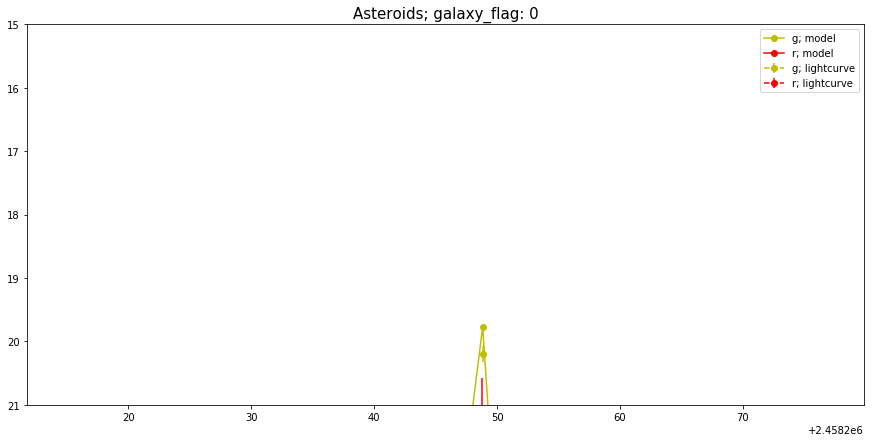

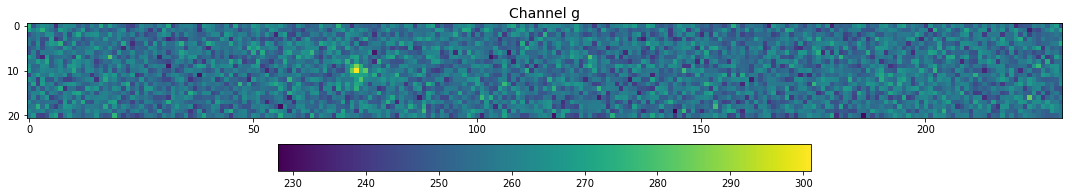

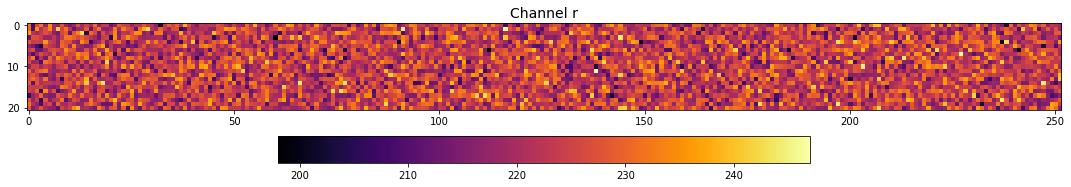


Field02
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
field images g: (60, 21, 21, 16) r: (60, 21, 21, 4)
lcs g: (60, 16) r: (60, 4)
obs days <HDF5 dataset "g": shape (16,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 16), type "<f8">
obs days <HDF5 dataset "r": shape (4,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 4), type "<f8">
Field02[50]
[26.48618591 26.38500834 26.17488253 26.35553217 26.28959584 26.6079942
 26.43987465 26.32955265 26.29656971 26.35092139 26.70846581 26.14272201
 26.27974319 26.28772986 26.31034422 26.31274939]
[25.94614232 26.76802146 26.3881768  25.97553563]


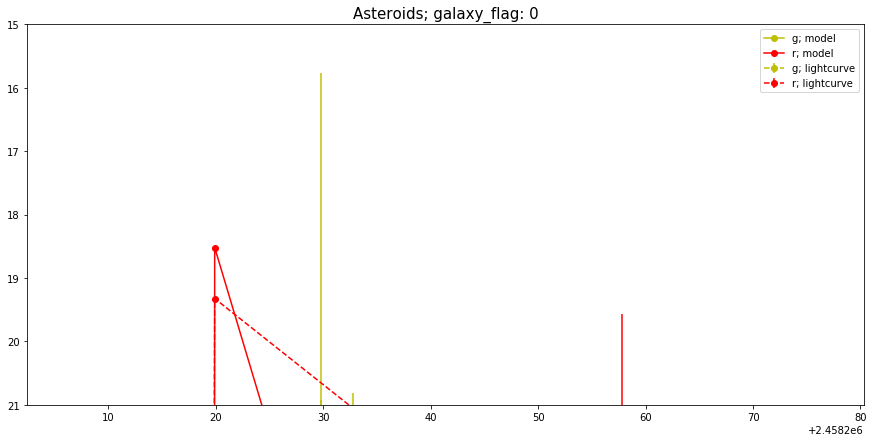

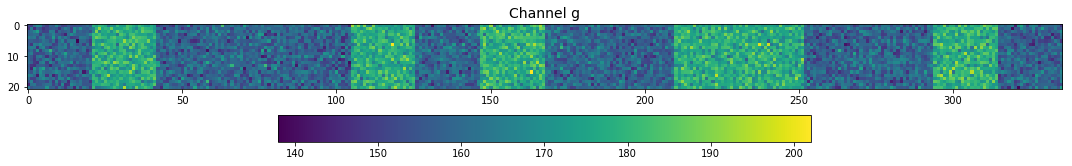

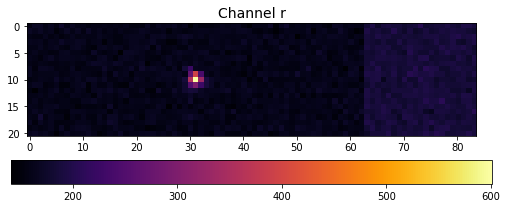


Field03
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
field images g: (60, 21, 21, 17) r: (60, 21, 21, 19)
lcs g: (60, 17) r: (60, 19)
obs days <HDF5 dataset "g": shape (17,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 17), type "<f8">
obs days <HDF5 dataset "r": shape (19,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 19), type "<f8">
Field03[24]
[26.43461978 26.50761855 26.3902905  26.53500128 26.4821589  26.70745921
 26.33647704 26.47158098 26.34997511 26.43666351 26.33681953 26.3477459
 26.29908526 26.31539392 26.29629469 26.30873668 26.32532084]
[26.4176029  26.34024751 26.35381556 26.37414324 26.38987589 26.35767972
 26.34971809 26.3224479  26.32326913 26.38619614 26.47812021 26.42374921
 26.2456522  26.30068612 26.24502587 26.1876502  26.19203329 26.25985718
 26.23543119]


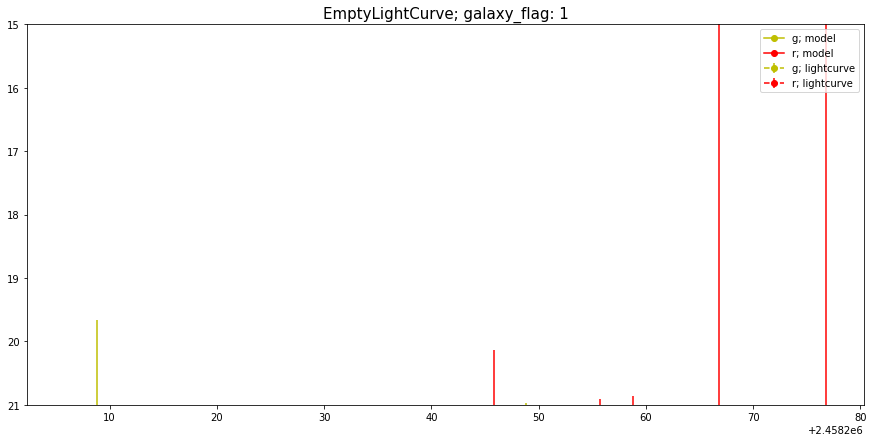

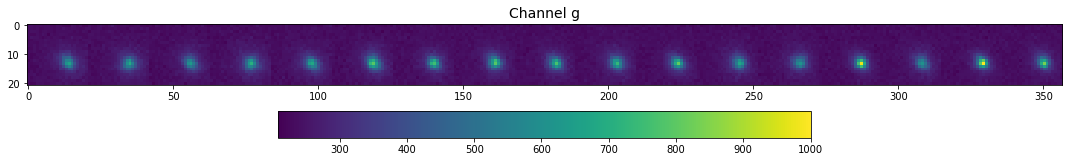

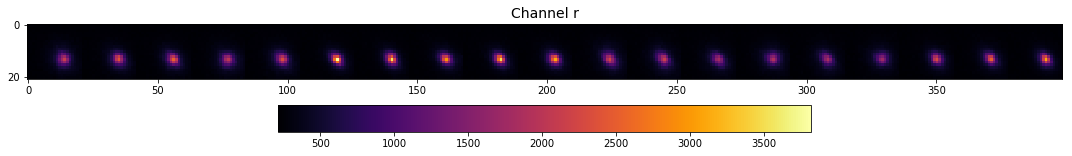


Field04
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
field images g: (60, 21, 21, 5) r: (60, 21, 21, 25)
lcs g: (60, 5) r: (60, 25)
obs days <HDF5 dataset "g": shape (5,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 5), type "<f8">
obs days <HDF5 dataset "r": shape (25,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 25), type "<f8">
Field04[49]
[26.55849743 26.2930063  26.1507628  26.15558004 26.28646362]
[26.62212873 26.16889715 26.07154167 26.22789276 26.04487073 26.37597895
 26.38959646 26.06861186 26.38837993 26.31823134 26.24360859 26.47229195
 26.10991776 26.20039332 26.29347789 26.35295057 26.37234175 26.20569265
 26.19645655 26.55542183 26.16373003 26.27930784 26.29779625 26.39992929
 26.16470385]


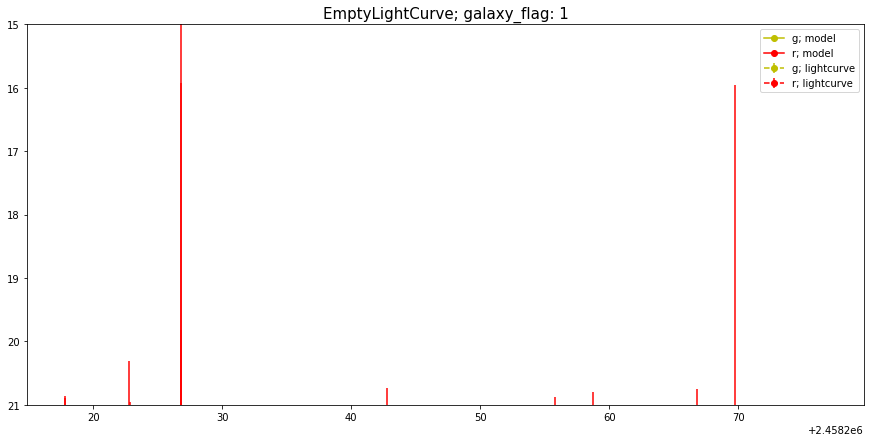

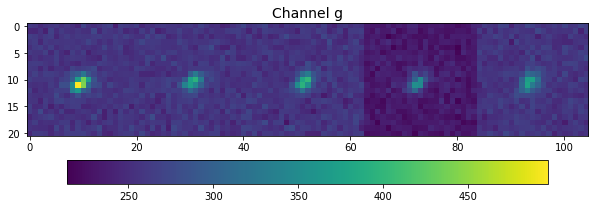

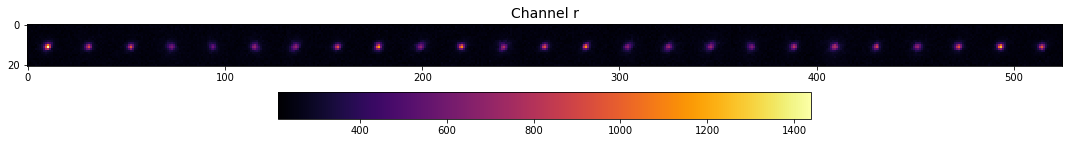


Field05
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
field images g: (60, 21, 21, 19) r: (60, 21, 21, 10)
lcs g: (60, 19) r: (60, 10)
obs days <HDF5 dataset "g": shape (19,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 19), type "<f8">
obs days <HDF5 dataset "r": shape (10,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 10), type "<f8">
Field05[0]
[26.39287186 26.51435614 26.46393538 26.52505112 26.56902146 26.54852998
 26.73001266 26.61645091 26.53457952 25.86534071 26.34086835 26.34072578
 26.40786743 26.36091256 26.4843291  26.50556099 26.28117311 26.38205183
 26.42923701]
[26.38455009 26.33410525 26.4057101  26.34354043 26.38025606 26.38787341
 26.37359679 26.38680732 26.30815041 26.3840605 ]


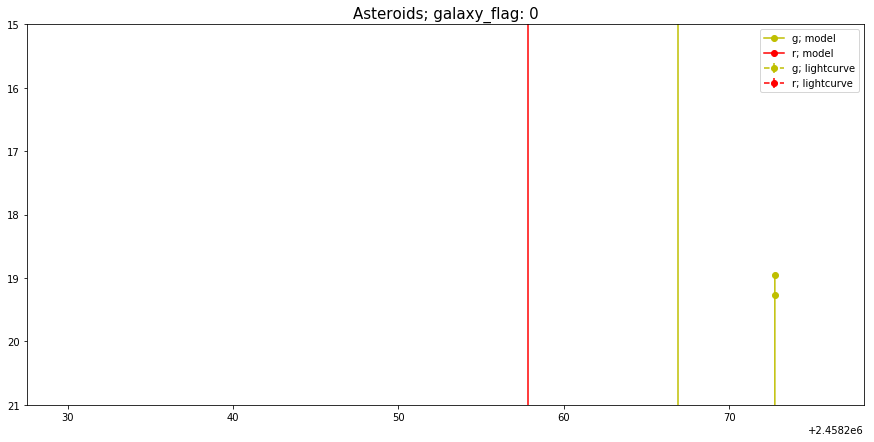

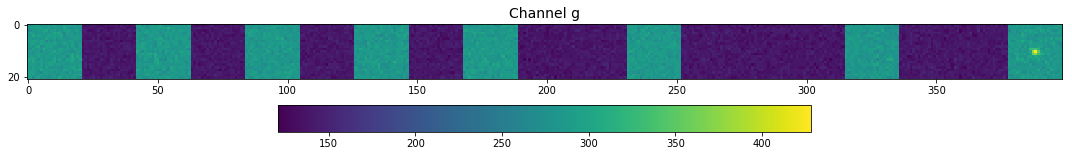

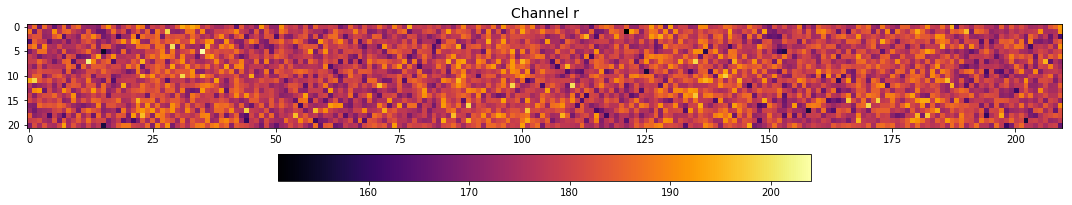


Field06
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
field images g: (60, 21, 21, 105) r: (60, 21, 21, 14)
lcs g: (60, 105) r: (60, 14)
obs days <HDF5 dataset "g": shape (105,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 105), type "<f8">
obs days <HDF5 dataset "r": shape (14,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 14), type "<f8">
Field06[21]
[26.49650502 26.41891146 26.4181397  26.42920446 27.02239132 26.56259894
 26.40330887 26.61541867 26.33381248 26.33576608 26.33756232 26.33562708
 26.33538675 26.33991933 26.335958   26.33759403 26.33677983 26.33782315
 26.49451113 26.50523996 26.50394034 26.41556787 26.33560824 26.52312899
 26.56964827 26.55583596 26.61603594 26.53200102 26.5182662  26.59484959
 26.56937933 26.54247451 26.48843026 26.50660062 26.5925231  26.49123025
 26.55028868 26.42588115 26.54895878 26.50309

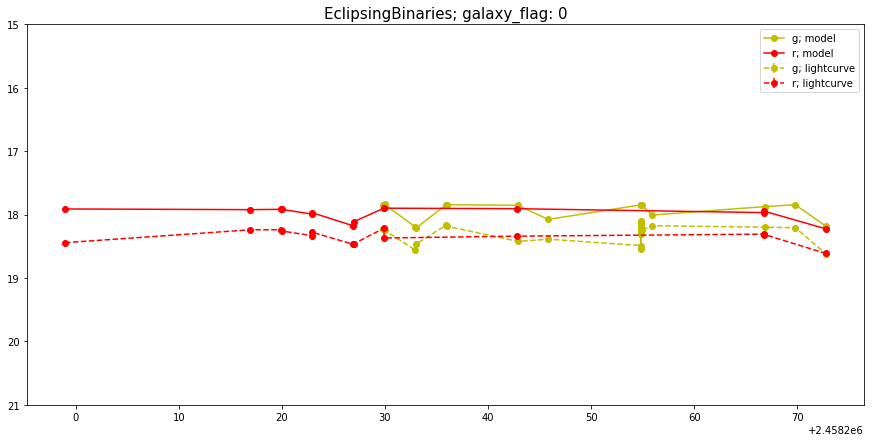

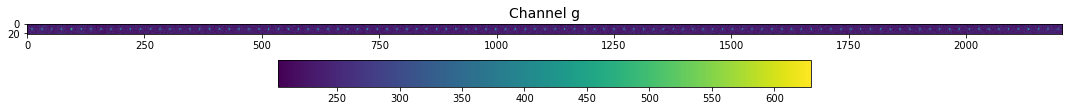

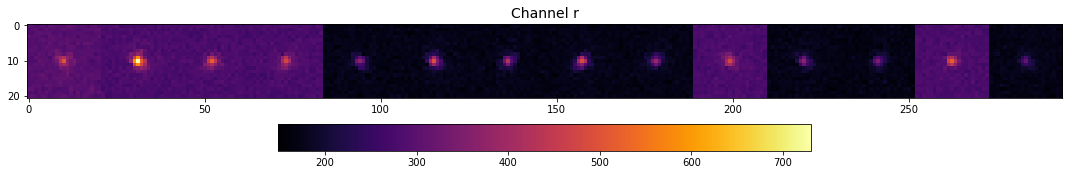


Field07
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
field images g: (60, 21, 21, 91) r: (60, 21, 21, 8)
lcs g: (60, 91) r: (60, 8)
obs days <HDF5 dataset "g": shape (91,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 91), type "<f8">
obs days <HDF5 dataset "r": shape (8,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 8), type "<f8">
Field07[50]
[26.99594188 26.42073298 25.9951458  26.45375466 26.5155158  26.65938997
 26.23008168 26.40487111 26.28420019 26.27019119 26.31381059 26.25532138
 26.28633881 26.24055171 26.33700895 26.2704798  26.29208958 26.30112696
 26.30781913 26.27325904 26.35433173 26.49340665 26.34711862 26.39399314
 26.38711131 26.28205144 26.27369428 26.32164967 26.40734529 26.40176284
 26.43722057 26.36249018 26.4349556  26.39869332 26.33381712 26.37106776
 26.37398493 26.30433834 26.30962539 26.21857512 26.2

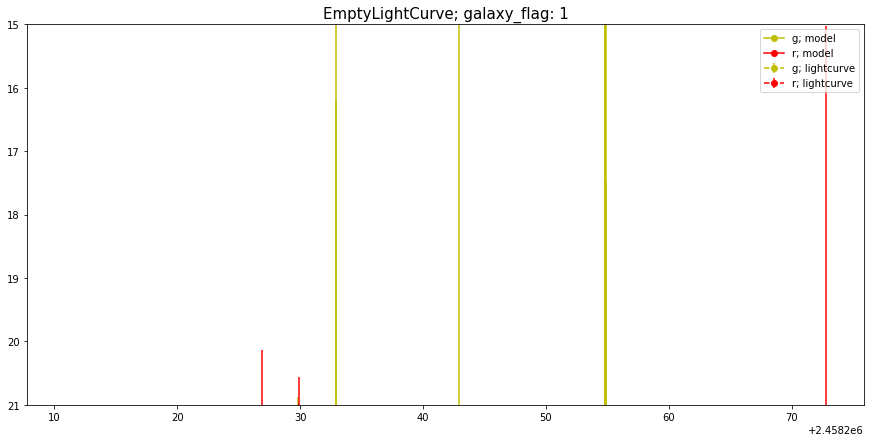

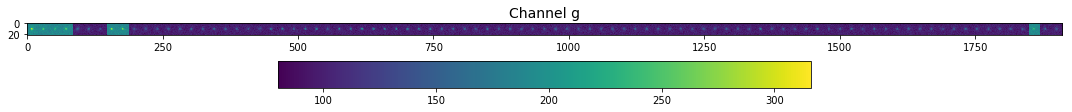

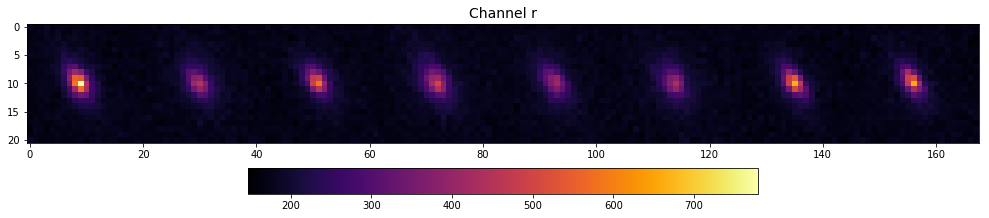


Field08
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
field images g: (60, 21, 21, 11) r: (60, 21, 21, 20)
lcs g: (60, 11) r: (60, 20)
obs days <HDF5 dataset "g": shape (11,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 11), type "<f8">
obs days <HDF5 dataset "r": shape (20,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 20), type "<f8">
Field08[41]
[26.40810108 26.42961121 26.21273816 26.36909258 26.49638724 26.51942635
 26.73890972 26.39906001 26.19021714 26.33974695 26.38551438]
[26.36878061 26.32589507 26.48044598 26.50117552 26.47763991 26.47616589
 26.39594305 26.3268038  26.12698007 26.35020769 27.2017585  26.51935053
 26.28382552 26.22549307 26.26910734 26.24277401 26.04935801 26.18053532
 26.32071173 26.29425216]


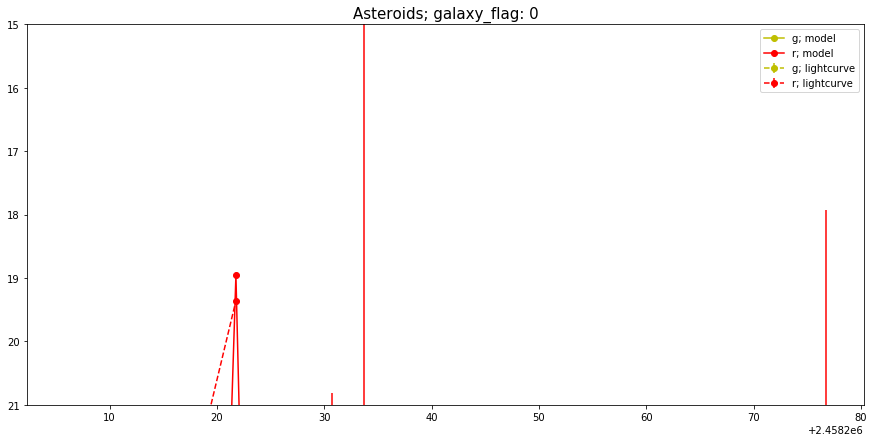

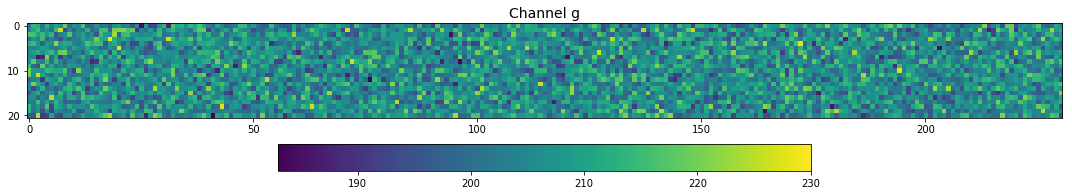

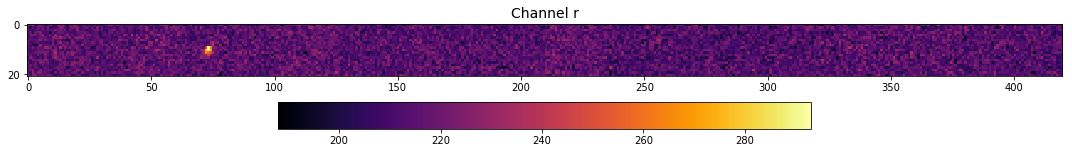


Field09
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
field images g: (60, 21, 21, 13) r: (60, 21, 21, 11)
lcs g: (60, 13) r: (60, 11)
obs days <HDF5 dataset "g": shape (13,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 13), type "<f8">
obs days <HDF5 dataset "r": shape (11,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 11), type "<f8">
Field09[41]
[26.45274353 26.4534713  26.52228987 26.46067679 26.23057854 26.3125248
 26.44261169 26.34179533 26.34356511 26.38233984 26.40701628 26.387784
 26.33846438]
[26.48004794 26.39842534 26.43772697 26.39914238 26.29949629 26.27600777
 26.29796231 26.24267972 26.31086648 26.30238974 26.28075755]


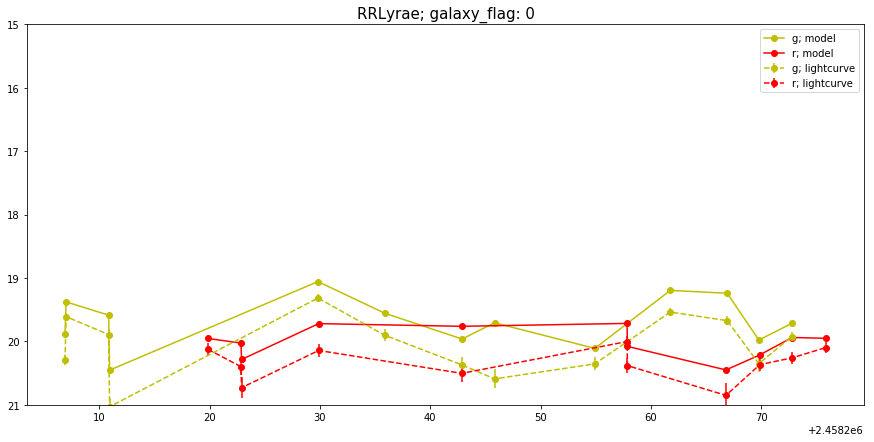

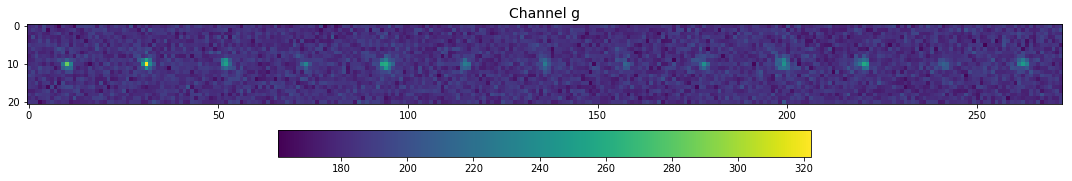

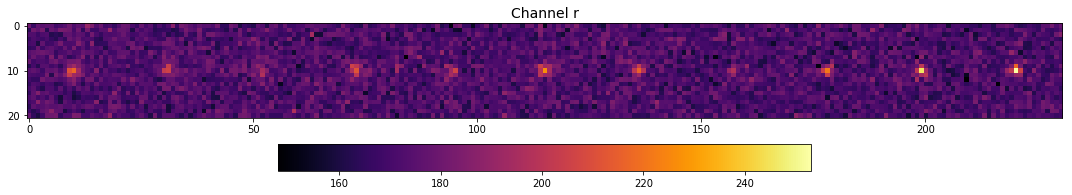


Field10
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
field images g: (60, 21, 21, 20) r: (60, 21, 21, 14)
lcs g: (60, 20) r: (60, 14)
obs days <HDF5 dataset "g": shape (20,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 20), type "<f8">
obs days <HDF5 dataset "r": shape (14,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 14), type "<f8">
Field10[35]
[26.28825331 26.80556393 26.15838313 26.19257379 26.08623612 26.41730893
 26.53821588 25.76427257 26.63704598 26.60256267 26.14522469 26.34882271
 26.15043819 26.43432188 26.30002654 26.36313605 26.38170457 26.57368255
 26.30550718 26.38543308]
[26.19711983 26.43221879 26.50461853 26.05596542 26.86675549 26.9413166
 26.58708036 26.29746068 26.2804358  26.24495411 26.23238969 26.33258545
 26.34264934 26.2444551 ]


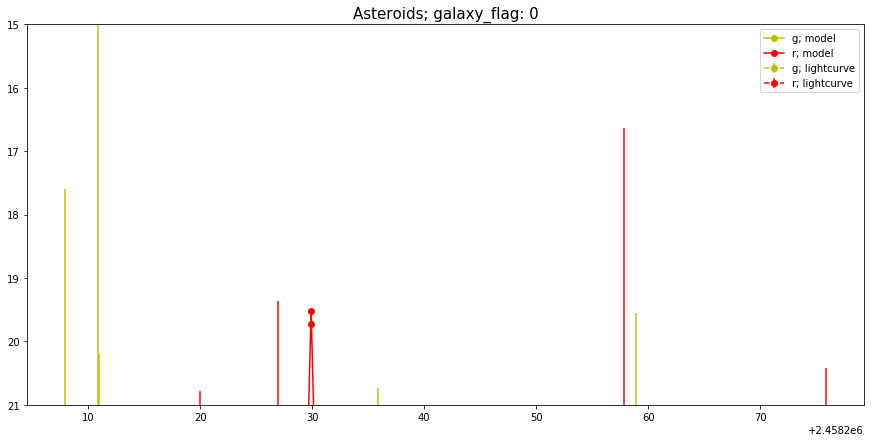

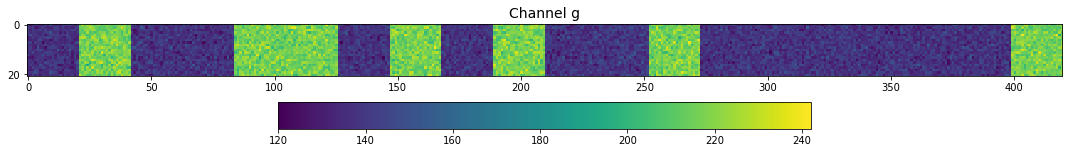

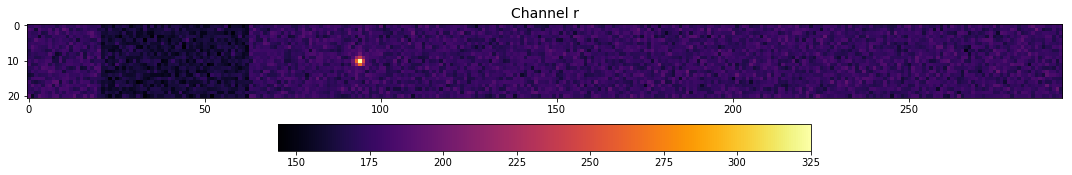


Field11
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
field images g: (60, 21, 21, 13) r: (60, 21, 21, 7)
lcs g: (60, 13) r: (60, 7)
obs days <HDF5 dataset "g": shape (13,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 13), type "<f8">
obs days <HDF5 dataset "r": shape (7,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 7), type "<f8">
Field11[12]
[26.41345    26.37969887 26.27755094 26.52501595 26.33982611 26.24804068
 26.56022704 26.5188427  26.62773228 26.26230884 26.33424568 26.41764712
 26.25804007]
[26.41750801 26.2782346  26.34014273 26.36979854 26.27827346 26.31590903
 26.307096  ]


/home/esteban/anaconda3/envs/tf/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()
/home/esteban/anaconda3/envs/tf/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


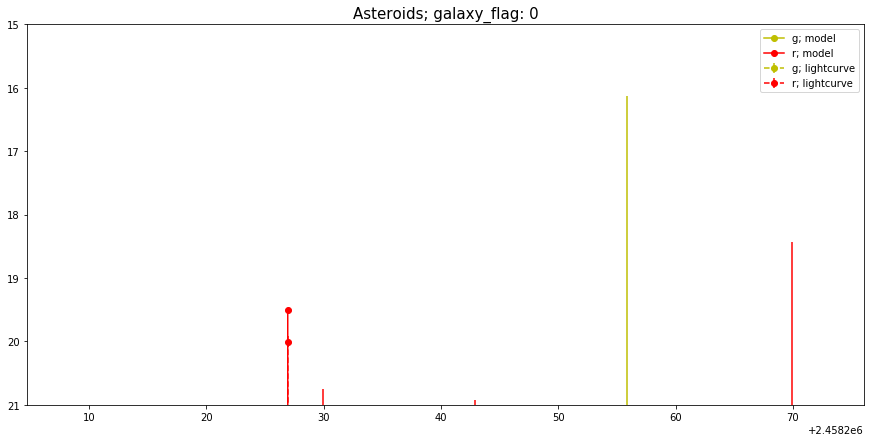

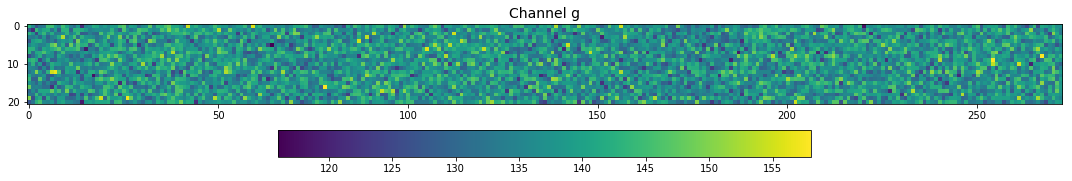

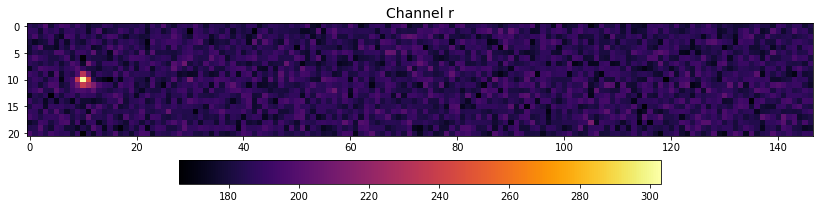


Field12
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
field images g: (60, 21, 21, 19) r: (60, 21, 21, 22)
lcs g: (60, 19) r: (60, 22)
obs days <HDF5 dataset "g": shape (19,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 19), type "<f8">
obs days <HDF5 dataset "r": shape (22,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 22), type "<f8">
Field12[55]
[26.98395264 26.36453962 26.52057135 26.31178415 26.60232782 26.54424596
 26.49996185 26.14681864 26.36551261 26.40208447 26.37468219 26.29768229
 26.4419893  26.51656699 26.58051574 26.49037528 26.4333297  26.35448182
 26.48385859]
[26.22412694 26.51802731 26.60938466 26.36757469 26.41306913 26.34703898
 26.65768981 26.61114228 26.6192379  26.85643542 26.34026325 26.38228142
 26.36329901 26.43696749 26.32810843 26.37009203 26.31939185 26.28838778
 26.32717538 26.3096143  26.3119676

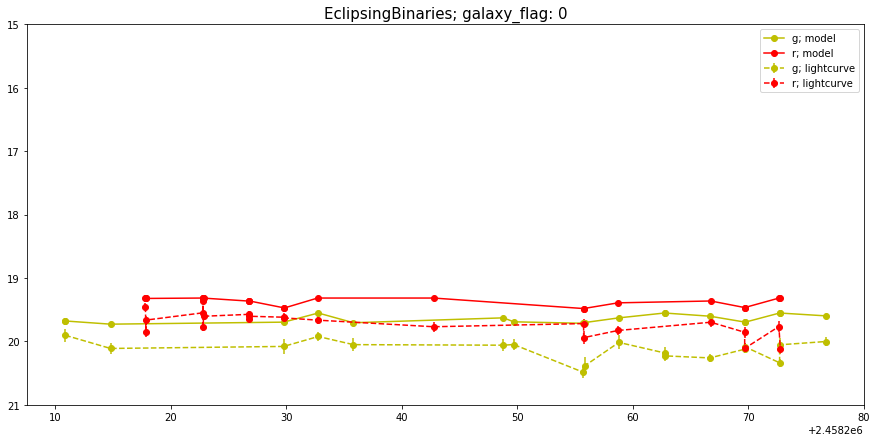

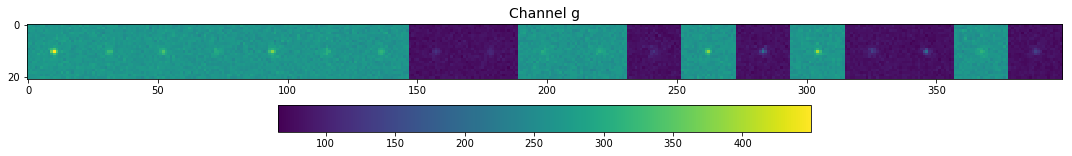

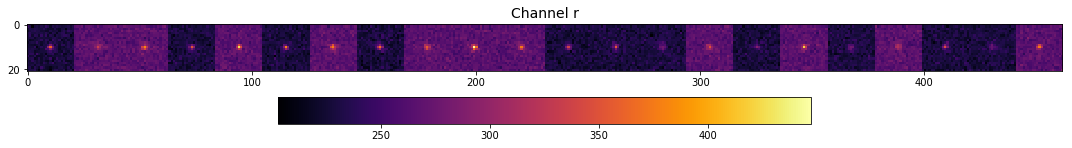


Field13
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
field images g: (60, 21, 21, 7) r: (60, 21, 21, 16)
lcs g: (60, 7) r: (60, 16)
obs days <HDF5 dataset "g": shape (7,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 7), type "<f8">
obs days <HDF5 dataset "r": shape (16,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 16), type "<f8">
Field13[15]
[26.70286322 26.23468769 26.49698865 26.43438685 26.22108245 26.50604713
 26.43474901]
[26.54242349 26.13755536 26.1530695  26.35755098 26.35415018 26.46578121
 26.40903127 26.45493245 26.22212434 26.38396859 26.22006726 26.54615617
 26.4626236  26.31727493 26.45786655 26.08799183]


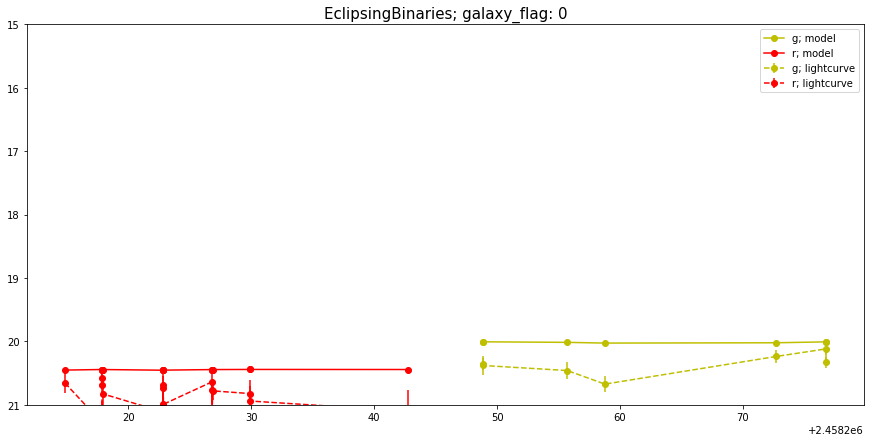

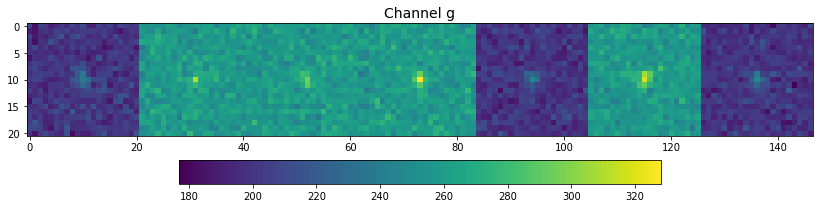

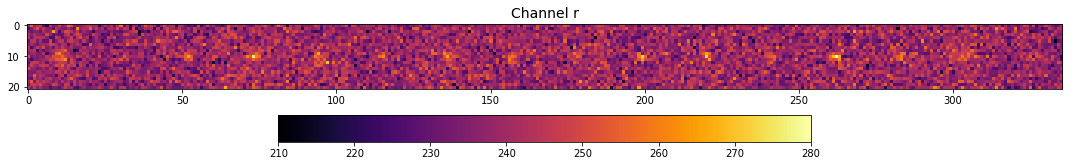


Field14
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
field images g: (60, 21, 21, 3) r: (60, 21, 21, 17)
lcs g: (60, 3) r: (60, 17)
obs days <HDF5 dataset "g": shape (3,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 3), type "<f8">
obs days <HDF5 dataset "r": shape (17,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 17), type "<f8">
Field14[42]
[26.46990883 26.35215497 26.33333421]
[26.31407785 26.18108034 26.29325414 26.35738361 26.07321858 26.37787569
 27.02476549 26.3184849  26.38369977 26.34937799 26.245561   26.25084436
 26.23414242 26.2586571  26.28988171 26.27077067 26.17331588]


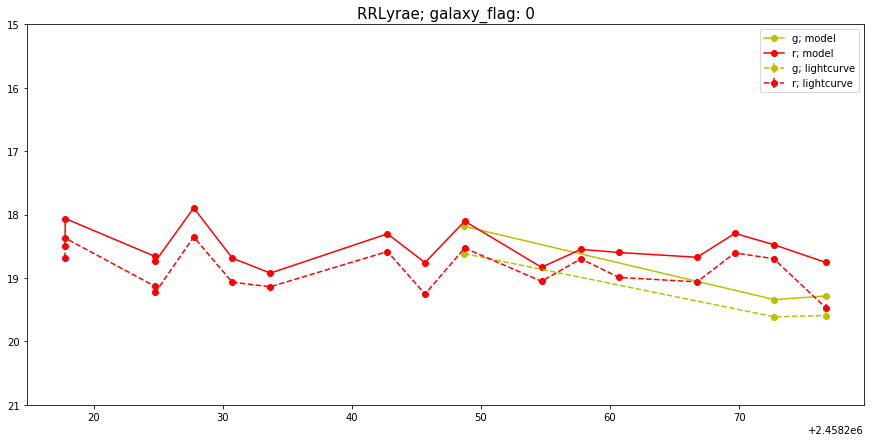

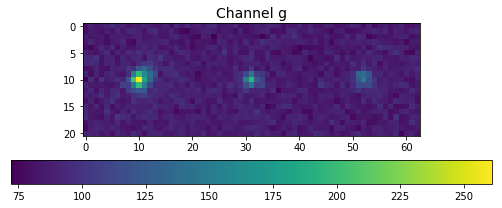

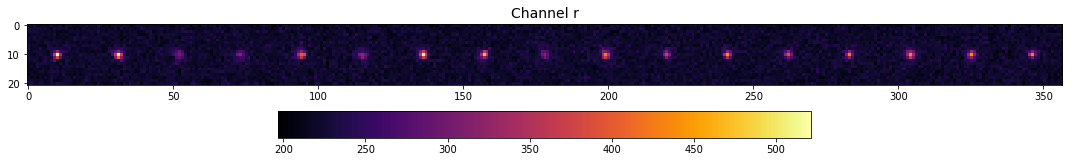


Field15
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
field images g: (60, 21, 21, 5) r: (60, 21, 21, 15)
lcs g: (60, 5) r: (60, 15)
obs days <HDF5 dataset "g": shape (5,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 5), type "<f8">
obs days <HDF5 dataset "r": shape (15,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 15), type "<f8">
Field15[27]
[26.40157533 26.40380049 26.40419936 26.28686678 26.31110442]
[26.37246299 26.24979377 26.41643155 26.57889831 26.33097982 26.09645367
 26.35492682 26.36864126 26.68612754 26.38083231 26.29021525 26.25359261
 26.10827136 26.25687385 26.32913601]


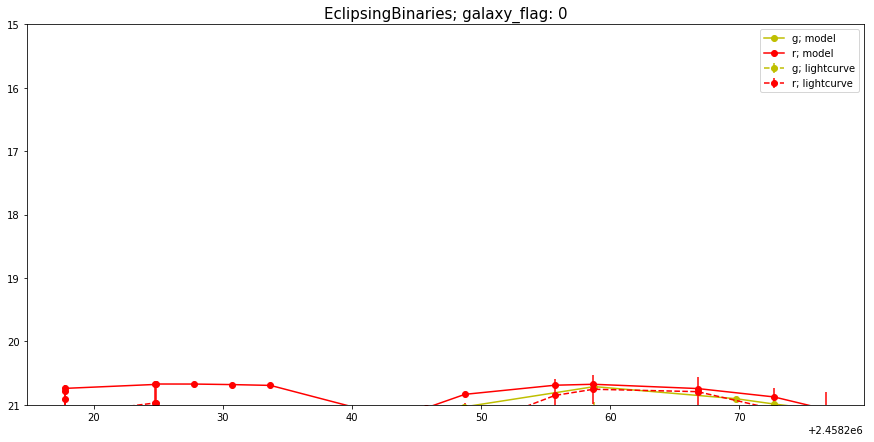

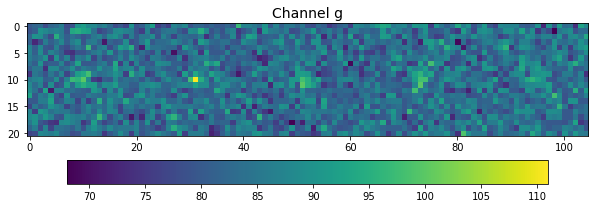

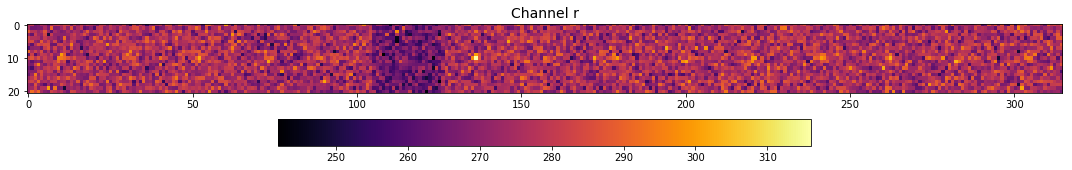


Field17
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
field images g: (60, 21, 21, 59) r: (60, 21, 21, 7)
lcs g: (60, 59) r: (60, 7)
obs days <HDF5 dataset "g": shape (59,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 59), type "<f8">
obs days <HDF5 dataset "r": shape (7,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 7), type "<f8">
Field17[42]
[26.34117961 26.34298491 26.68069363 26.22724545 26.31838787 26.28486192
 26.44344795 26.35665143 26.45767391 26.42264783 26.39428413 26.42873836
 26.45874381 26.41524518 26.46734059 26.4303652  26.45889819 26.4300555
 26.31969428 26.30861831 26.22202218 26.27594995 26.28118765 26.27969193
 26.22275901 26.31943095 26.26488626 26.27100646 26.29066944 26.32661974
 26.3569324  26.32652104 26.26677763 26.24951661 26.28183317 26.34404802
 26.38636971 26.13628519 26.28053451 26.33543241 26.31

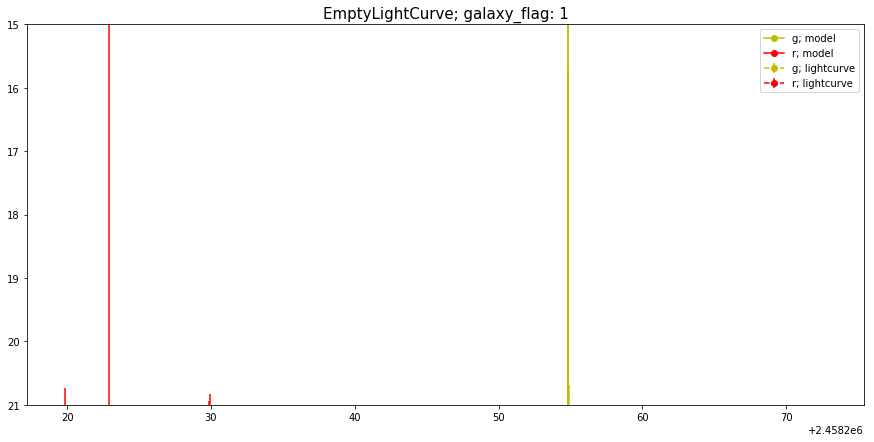

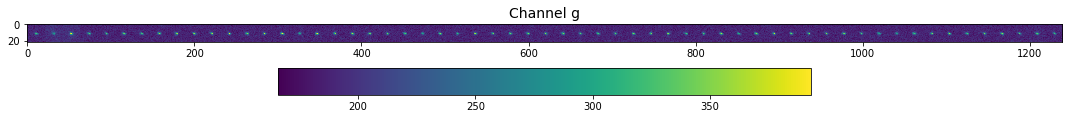

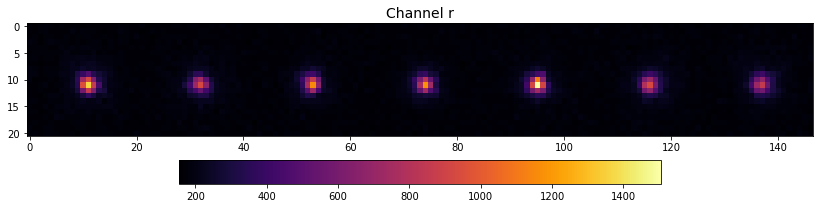


Field18
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
field images g: (60, 21, 21, 19) r: (60, 21, 21, 1)
lcs g: (60, 19) r: (60, 1)
obs days <HDF5 dataset "g": shape (19,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 19), type "<f8">
obs days <HDF5 dataset "r": shape (1,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 1), type "<f8">
Field18[16]
[26.26766384 26.48668778 26.74383426 26.50559986 26.82432938 26.60562098
 26.43245637 26.49212325 26.37850797 26.46215427 26.48492551 26.49071634
 26.31731105 26.47176313 26.37844217 26.85250092 26.46425951 26.40413272
 26.40937388]
[26.10881793]


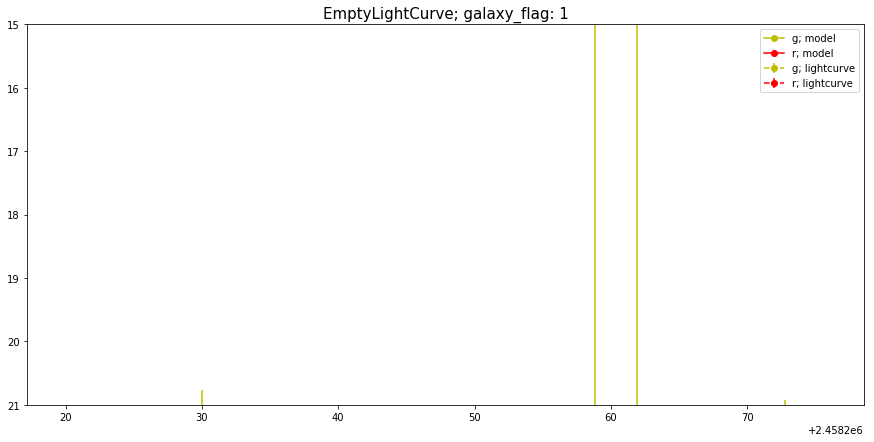

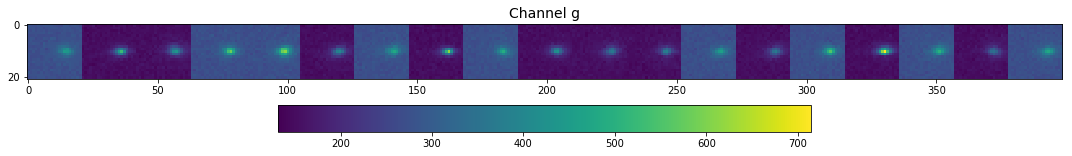

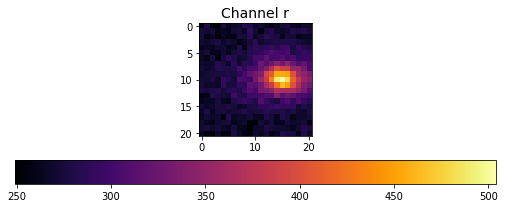


Field19
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
field images g: (60, 21, 21, 15) r: (60, 21, 21, 9)
lcs g: (60, 15) r: (60, 9)
obs days <HDF5 dataset "g": shape (15,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 15), type "<f8">
obs days <HDF5 dataset "r": shape (9,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 9), type "<f8">
Field19[24]
[26.51811242 26.0083313  26.31696963 26.24346149 26.28848898 26.26173806
 26.17190552 26.51549351 25.5206039  26.27227604 26.48882055 26.35223424
 26.42667925 26.27912664 26.39844978]
[26.2456404  26.3513521  26.21757495 26.59013319 26.38440669 26.31004024
 26.41533422 26.40334952 26.07977223]


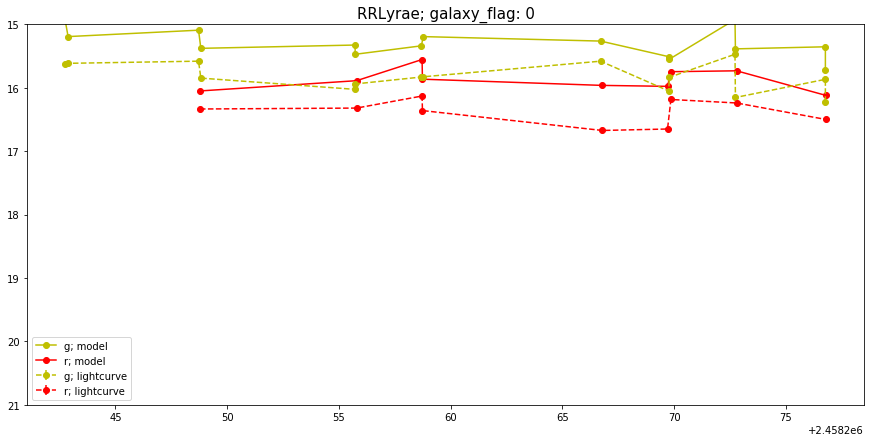

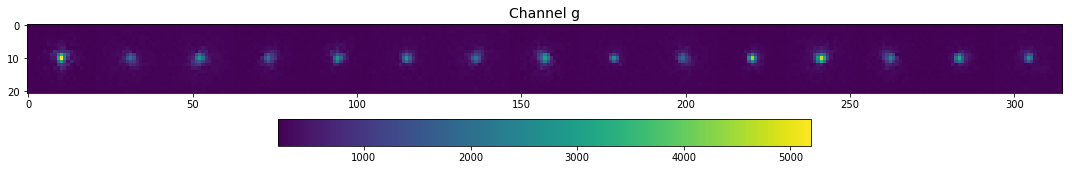

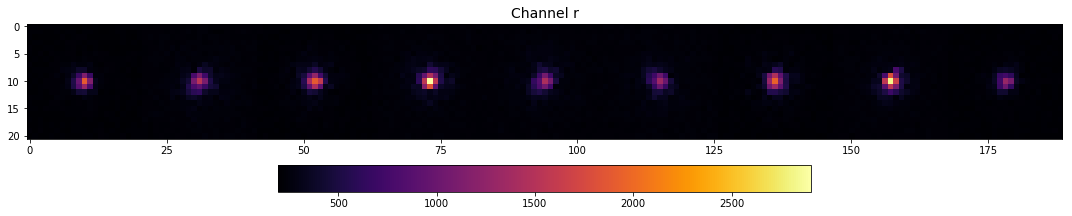


Field20
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
field images g: (60, 21, 21, 14) r: (60, 21, 21, 16)
lcs g: (60, 14) r: (60, 16)
obs days <HDF5 dataset "g": shape (14,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 14), type "<f8">
obs days <HDF5 dataset "r": shape (16,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 16), type "<f8">
Field20[58]
[26.44648182 26.57676232 26.45017433 26.54689336 26.53430665 26.46700478
 26.47603643 26.66036582 26.39864957 25.75980067 26.92523754 26.18210876
 26.41330314 26.65758705]
[26.2643801  26.41561878 26.20797944 26.48914373 26.3770169  26.314134
 26.40127468 26.31033051 26.2840277  26.59822345 26.34068656 26.34693646
 26.19758296 26.23495626 26.37624586 26.14758217]


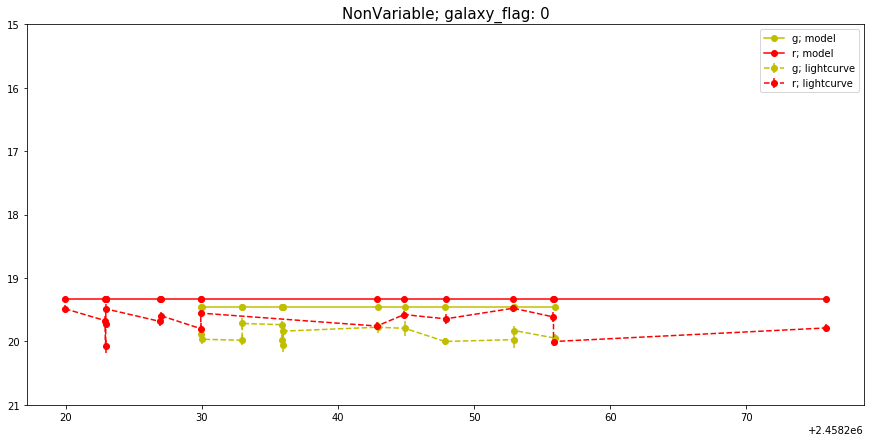

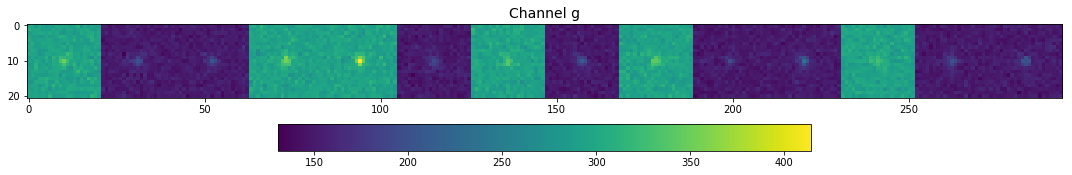

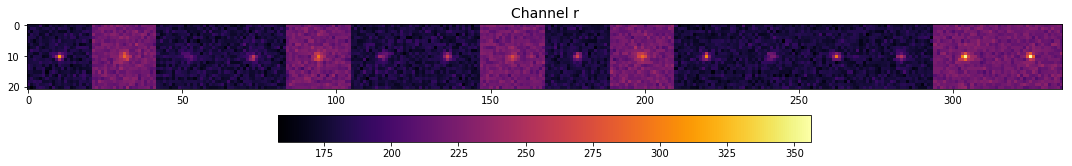


Field21
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
field images g: (60, 21, 21, 21) r: (60, 21, 21, 15)
lcs g: (60, 21) r: (60, 15)
obs days <HDF5 dataset "g": shape (21,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 21), type "<f8">
obs days <HDF5 dataset "r": shape (15,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 15), type "<f8">
Field21[10]
[26.47778749 26.64141083 26.54909158 26.65211678 26.75295103 26.35099614
 26.19382787 26.37685049 26.30599904 26.34290946 26.43520975 26.39714825
 26.31927776 26.18198287 26.33724666 26.41443491 26.29755664 26.1942153
 26.61764371 26.45349276 26.27766335]
[26.53065646 26.32494974 26.00081599 26.47058702 26.21708035 26.50843358
 26.24494886 26.10392165 26.17192018 26.12061203 25.62620485 26.45141172
 26.40186501 26.22435176 26.1484139 ]


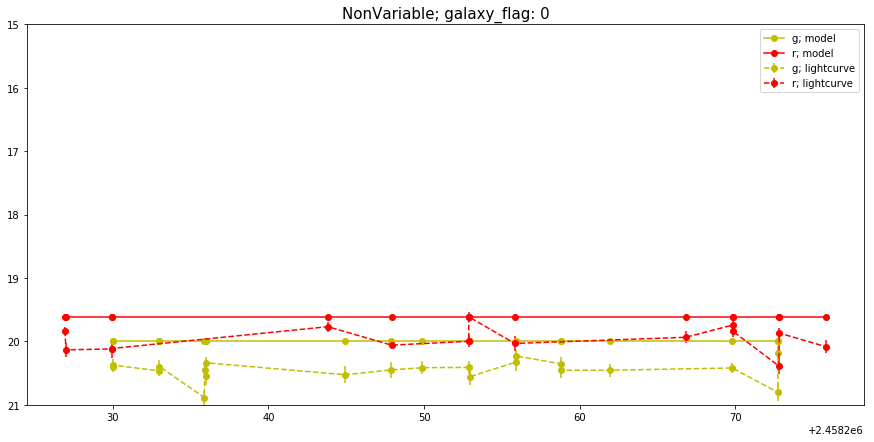

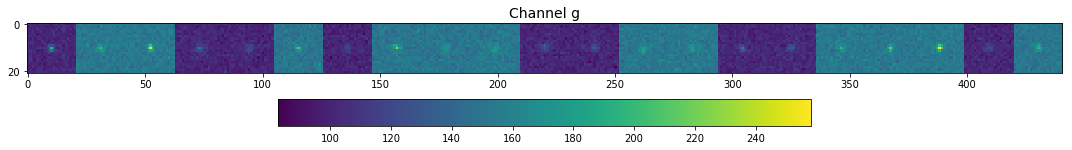

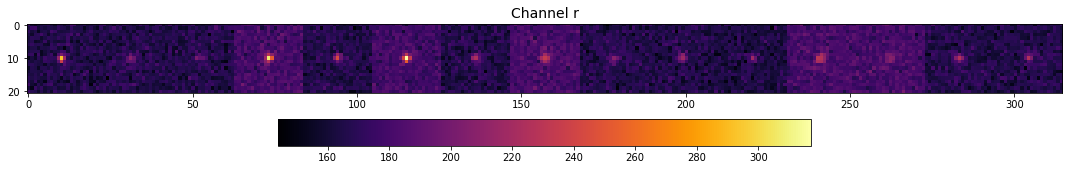


Field22
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
field images g: (60, 21, 21, 11) r: (60, 21, 21, 13)
lcs g: (60, 11) r: (60, 13)
obs days <HDF5 dataset "g": shape (11,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 11), type "<f8">
obs days <HDF5 dataset "r": shape (13,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 13), type "<f8">
Field22[52]
[26.31296372 26.56120014 26.22918367 26.58735347 26.240623   26.33844435
 26.31557357 26.29824936 26.33464551 26.34732127 26.32530761]
[26.41352785 26.5433737  26.42317426 26.06379378 26.5522064  26.39455187
 26.14341271 26.41280758 26.44846821 26.26601934 26.8658123  26.11854267
 26.1859169 ]


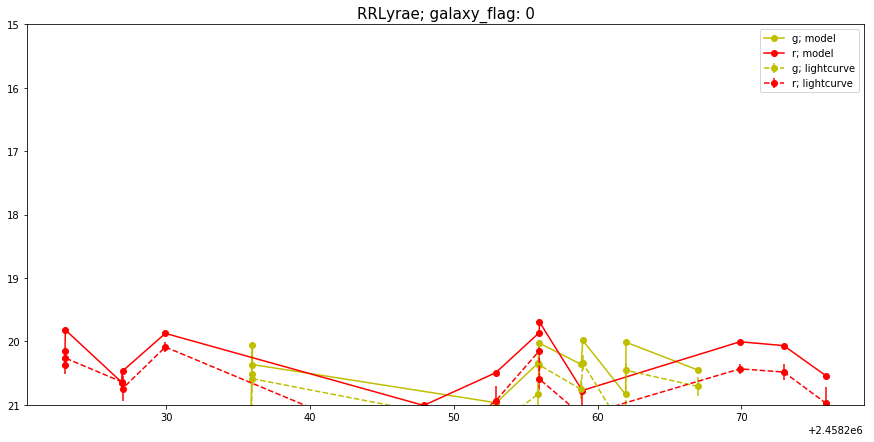

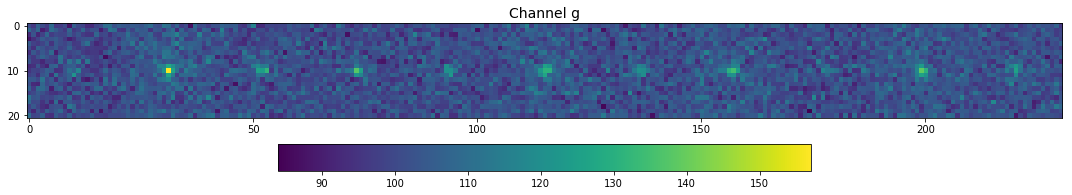

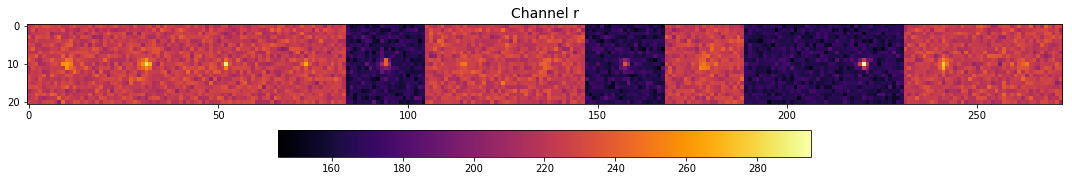


Field23
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
field images g: (60, 21, 21, 28) r: (60, 21, 21, 14)
lcs g: (60, 28) r: (60, 14)
obs days <HDF5 dataset "g": shape (28,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 28), type "<f8">
obs days <HDF5 dataset "r": shape (14,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 14), type "<f8">
Field23[23]
[26.29197085 26.43355083 26.48917413 26.65155828 26.50760484 26.42772079
 26.82568502 26.63725841 26.31569958 26.58509707 26.41045189 26.34430254
 26.15378618 26.20373166 26.40286815 26.69604802 26.20719898 26.10067689
 25.9010973  26.2202425  26.4648962  26.10880041 26.64110613 26.70234728
 26.45884705 26.25914955 26.34194517 26.16474116]
[26.3079536  25.81289029 26.34677637 26.44410992 26.28763115 26.53538167
 26.37335873 26.55846238 26.23973191 26.39342058 26.38370264 26.30146396

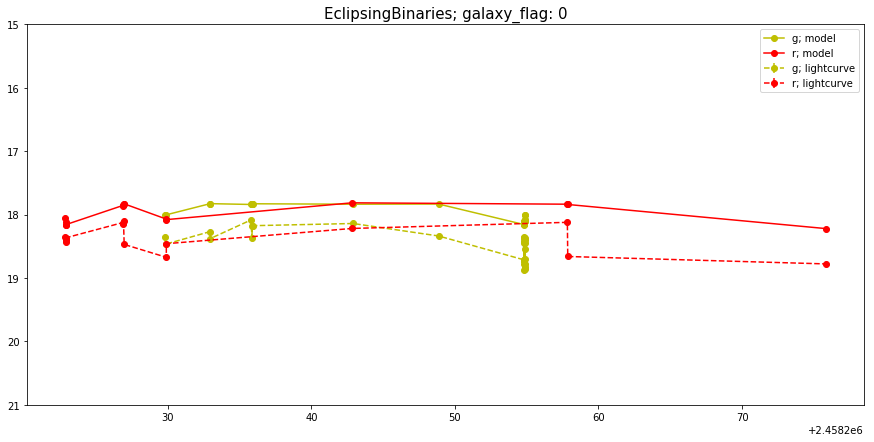

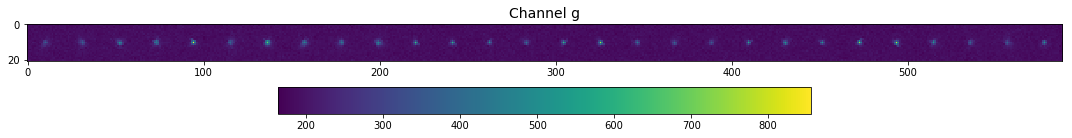

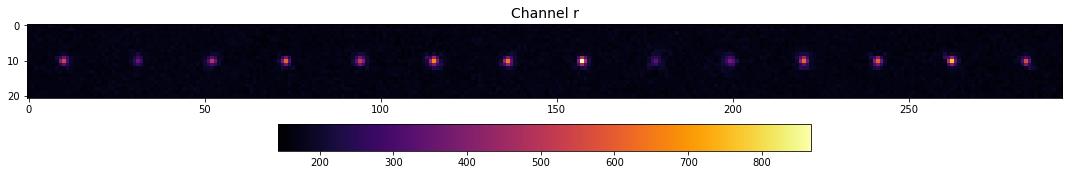


Field24
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
field images g: (60, 21, 21, 98) r: (60, 21, 21, 2)
lcs g: (60, 98) r: (60, 2)
obs days <HDF5 dataset "g": shape (98,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 98), type "<f8">
obs days <HDF5 dataset "r": shape (2,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 2), type "<f8">
Field24[35]
[26.4942143  26.48628402 26.47987139 26.58285618 26.63062072 26.49703062
 26.4816649  26.47474611 26.45234787 26.44716835 26.41130257 26.42432427
 26.45329177 26.45363688 26.43121672 26.44319105 26.31319416 26.46474993
 26.3889792  26.2553407  26.44112062 26.41899967 26.36310565 26.42255092
 26.48683333 26.36271906 26.3953985  26.41611171 26.41976225 26.38431537
 26.47228241 26.44199395 26.39151013 26.38047659 26.43081117 26.31516612
 26.42001438 26.31833005 26.38174939 26.40225542 26.2

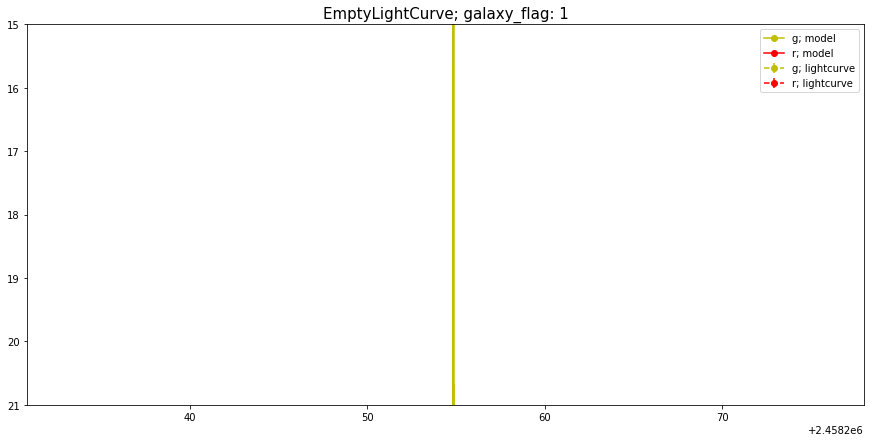

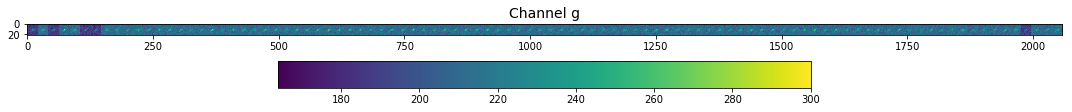

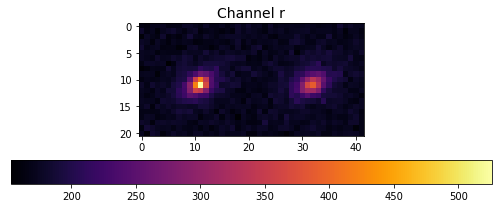


Field25
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
field images g: (60, 21, 21, 4) r: (60, 21, 21, 20)
lcs g: (60, 4) r: (60, 20)
obs days <HDF5 dataset "g": shape (4,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 4), type "<f8">
obs days <HDF5 dataset "r": shape (20,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 20), type "<f8">
Field25[12]
[26.34015238 26.31266737 26.2684778  26.44564652]
[26.59914708 26.57000554 26.51811826 26.71915102 26.85175252 26.46493161
 26.42110336 26.34338474 26.30122662 26.42633903 26.50096714 26.40483499
 26.25399756 26.29649079 25.64148104 25.96143734 26.34126842 26.33645689
 26.33592057 26.30416811]


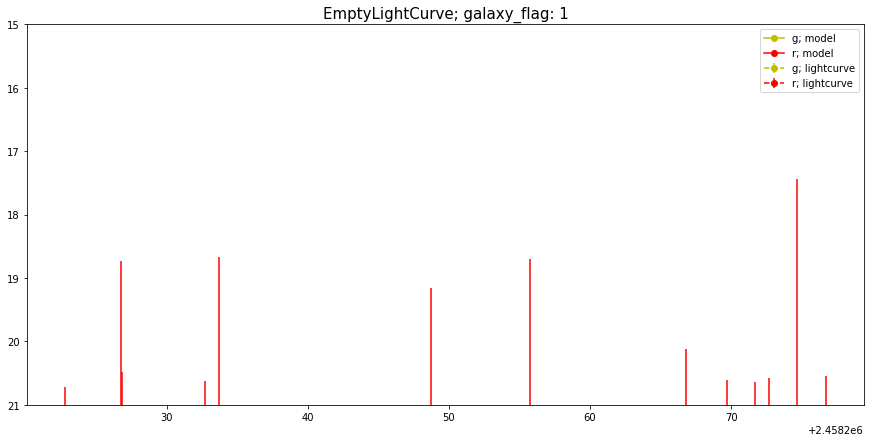

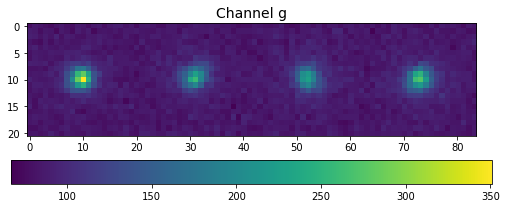

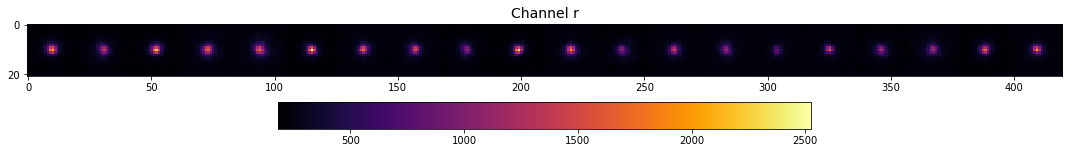


Field26
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
field images g: (60, 21, 21, 22) r: (60, 21, 21, 19)
lcs g: (60, 22) r: (60, 19)
obs days <HDF5 dataset "g": shape (22,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 22), type "<f8">
obs days <HDF5 dataset "r": shape (19,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 19), type "<f8">
Field26[58]
[26.78838336 26.1050384  25.23525822 26.31306863 26.27642071 26.53612065
 26.42649758 26.31020427 26.33105505 26.37353146 26.31067312 26.15993476
 26.30225539 26.369102   26.263376   26.65586293 26.41361356 26.45308542
 26.32530582 26.32141399 26.37343895 26.31131554]
[26.74025118 26.17715895 26.39759576 26.2803812  26.37754953 26.22179914
 26.29156387 26.20303738 26.32819521 26.07245362 26.46253312 26.16313779
 26.20223701 26.21667528 26.3185389  26.34600878 26.21192133 26.17448115

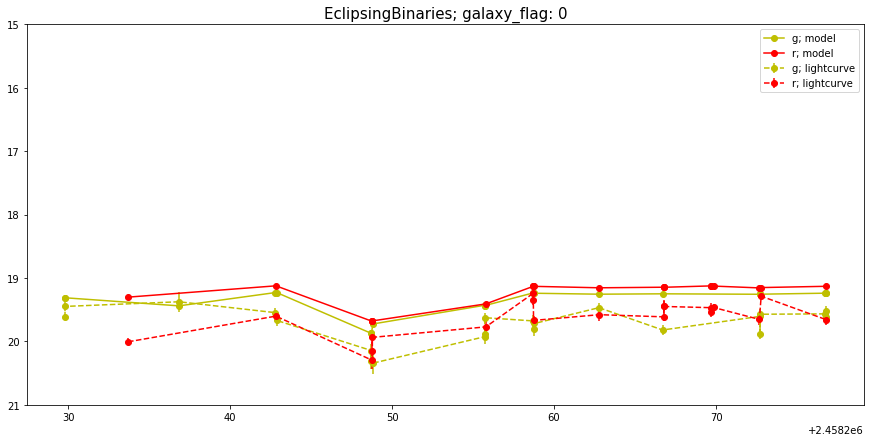

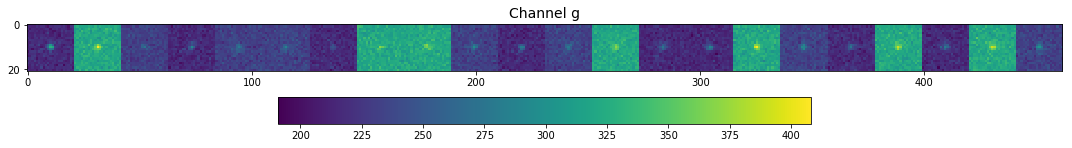

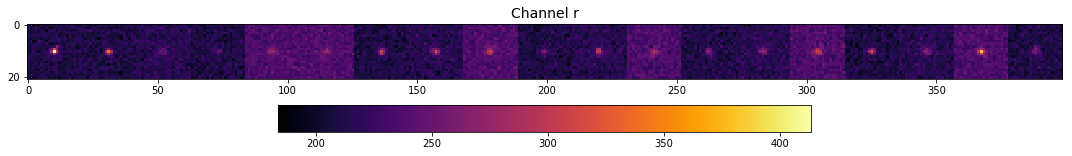


Field27
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
field images g: (60, 21, 21, 94) r: (60, 21, 21, 5)
lcs g: (60, 94) r: (60, 5)
obs days <HDF5 dataset "g": shape (94,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 94), type "<f8">
obs days <HDF5 dataset "r": shape (5,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 5), type "<f8">
Field27[48]
[26.40240407 26.43388343 26.43183398 26.62855542 25.94761956 25.91159546
 25.77169561 26.14634144 26.10875475 26.1165607  26.08903503 25.74071395
 26.25629175 26.15618062 26.17977905 26.33674288 26.20762527 26.5875771
 25.94169748 26.2672745  26.21850669 25.81584132 26.24989974 26.47249413
 26.42711532 26.13962197 26.39648914 26.2030704  26.37669432 26.49798691
 26.38855159 26.23181379 26.24324679 26.29192781 26.4274025  26.38396502
 26.18799651 26.30153847 26.39617443 26.31348038 26.27

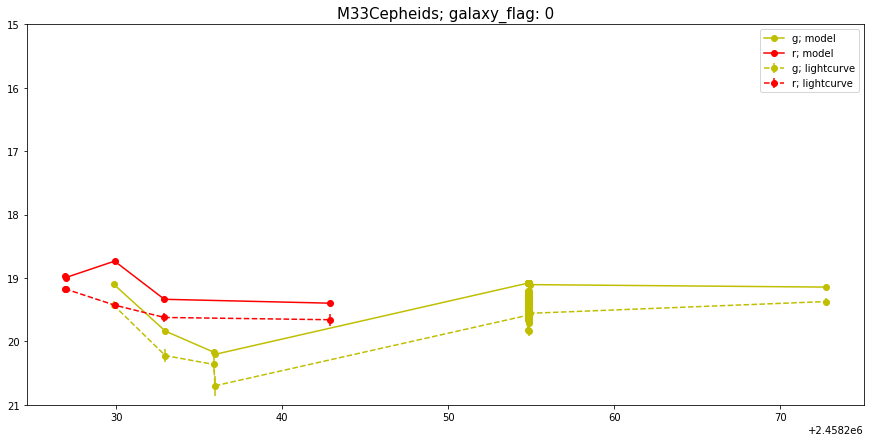

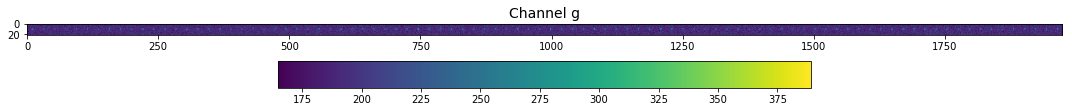

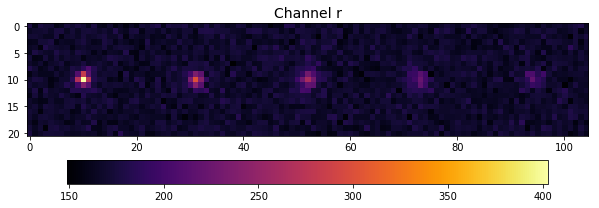


Field28
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
field images g: (60, 21, 21, 10) r: (60, 21, 21, 10)
lcs g: (60, 10) r: (60, 10)
obs days <HDF5 dataset "g": shape (10,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 10), type "<f8">
obs days <HDF5 dataset "r": shape (10,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 10), type "<f8">
Field28[6]
[26.42658007 26.52938223 26.40922105 26.61228335 26.53185761 26.42843103
 26.26814544 26.2756356  26.32226276 26.42549896]
[26.36154842 26.44749856 26.54209936 26.64966512 26.50530541 26.28039324
 26.24739468 26.42600179 26.3423723  26.32517636]


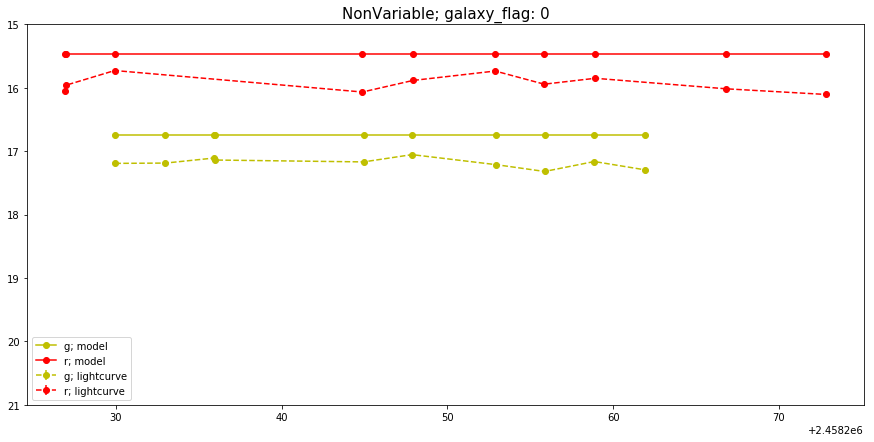

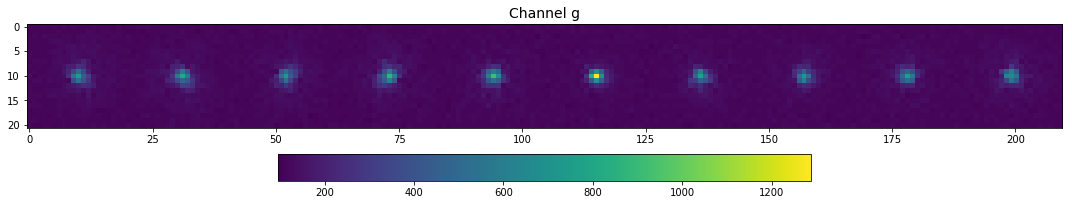

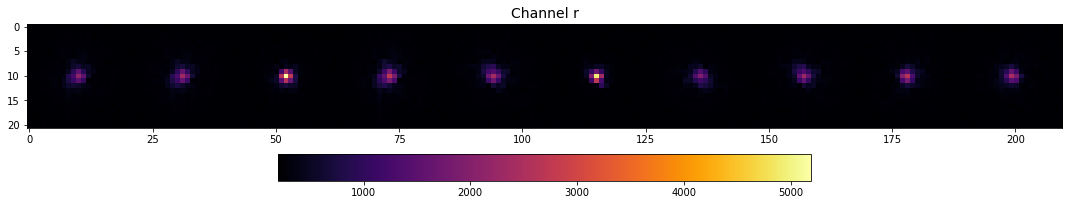


Field29
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
field images g: (60, 21, 21, 87) r: (60, 21, 21, 2)
lcs g: (60, 87) r: (60, 2)
obs days <HDF5 dataset "g": shape (87,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 87), type "<f8">
obs days <HDF5 dataset "r": shape (2,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 2), type "<f8">
Field29[4]
[26.28939903 26.43145144 26.35690022 26.51399541 26.38891137 26.48855221
 26.46117234 26.44089162 26.36074245 26.31042182 26.2217629  26.4954114
 25.71963429 26.43705571 26.47832024 26.3430599  25.96824074 26.55779898
 26.28204668 25.95087111 26.25560153 26.5331223  26.11406755 26.26524639
 26.4702661  26.19090819 26.13526094 26.40955257 26.48473072 26.03642225
 26.26645446 26.44650006 26.32769835 26.24572957 26.70455921 26.43771219
 26.42805231 26.49750853 26.19538891 26.72561586 26.655

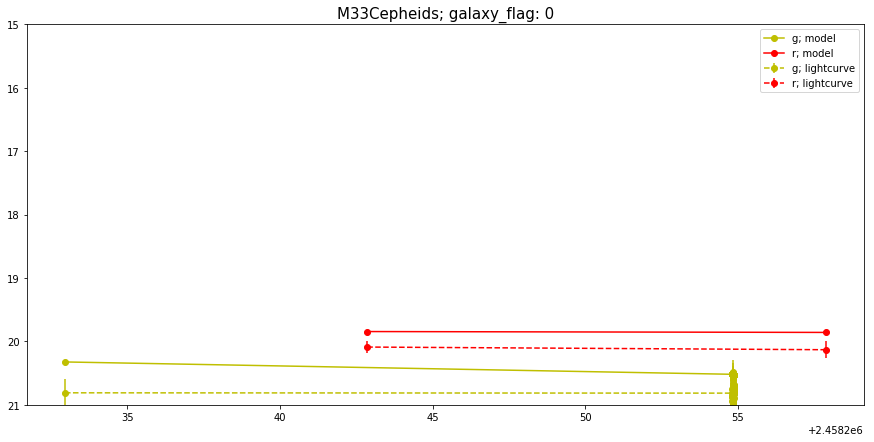

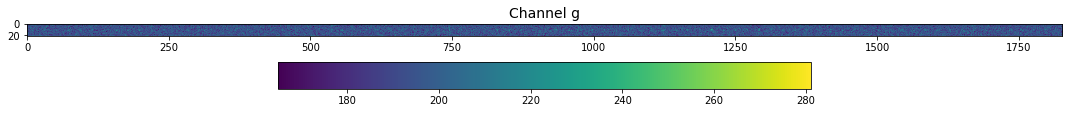

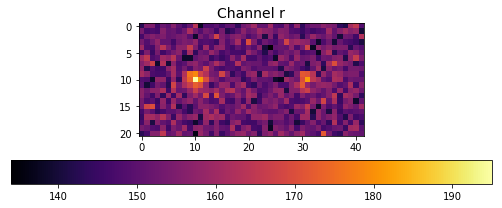


Field30
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
field images g: (60, 21, 21, 8) r: (60, 21, 21, 13)
lcs g: (60, 8) r: (60, 13)
obs days <HDF5 dataset "g": shape (8,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 8), type "<f8">
obs days <HDF5 dataset "r": shape (13,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 13), type "<f8">
Field30[35]
[26.46914339 26.55033708 26.3143965  26.29339194 26.23455334 26.3532846
 26.3188194  26.37690306]
[26.55623984 26.3905195  26.48547137 26.2592504  26.29868615 26.28645599
 26.27234542 26.29911315 26.23484385 26.14001822 26.21382201 26.22618806
 26.18329287]


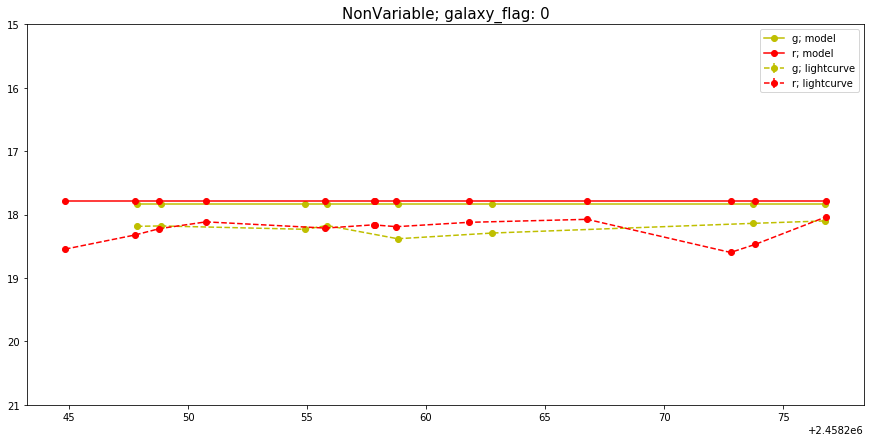

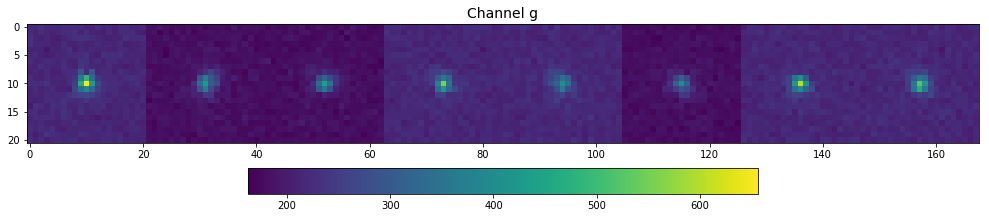

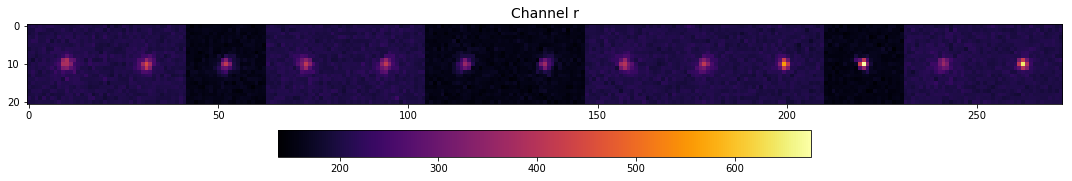


Field32
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
field images g: (60, 21, 21, 17) r: (60, 21, 21, 15)
lcs g: (60, 17) r: (60, 15)
obs days <HDF5 dataset "g": shape (17,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 17), type "<f8">
obs days <HDF5 dataset "r": shape (15,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 15), type "<f8">
Field32[9]
[26.49049306 26.58480597 26.3566072  26.34340477 26.33116937 26.33030021
 26.95644736 26.33556592 26.35234988 26.38162816 26.35800993 26.29613256
 26.3795768  26.3289274  26.32375371 26.34077978 26.32394266]
[26.31040359 26.30289602 26.27996349 26.28703284 26.2739923  26.28997493
 26.46551847 26.29165721 26.28663325 26.28108311 26.28639197 26.28867173
 26.28653193 26.29472256 26.2902863 ]


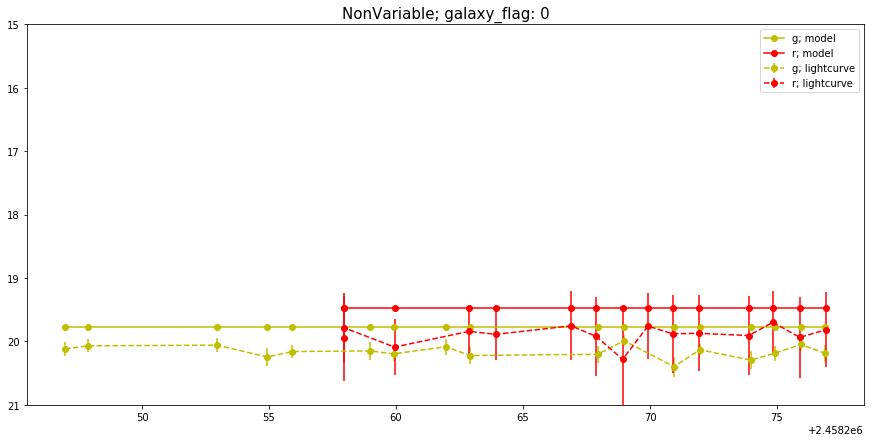

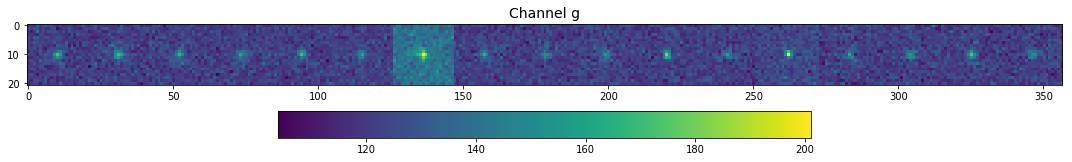

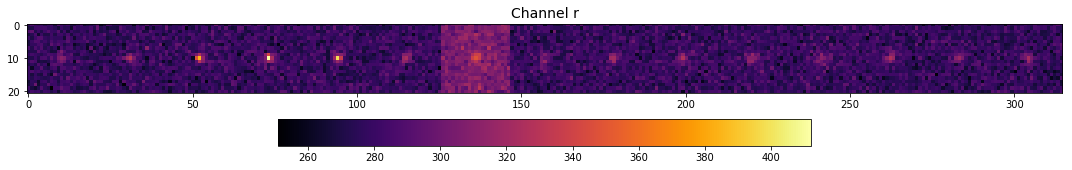


Field33
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
field images g: (60, 21, 21, 14) r: (60, 21, 21, 7)
lcs g: (60, 14) r: (60, 7)
obs days <HDF5 dataset "g": shape (14,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 14), type "<f8">
obs days <HDF5 dataset "r": shape (7,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 7), type "<f8">
Field33[48]
[26.57327664 26.81689596 26.44979024 26.18803501 26.28548324 26.53144205
 26.35048807 26.76767087 26.40183663 26.35494494 26.3825556  26.47559249
 26.34078205 26.30795825]
[26.37408149 26.55617654 26.16523504 26.21111715 26.42030811 26.41873157
 26.46660829]


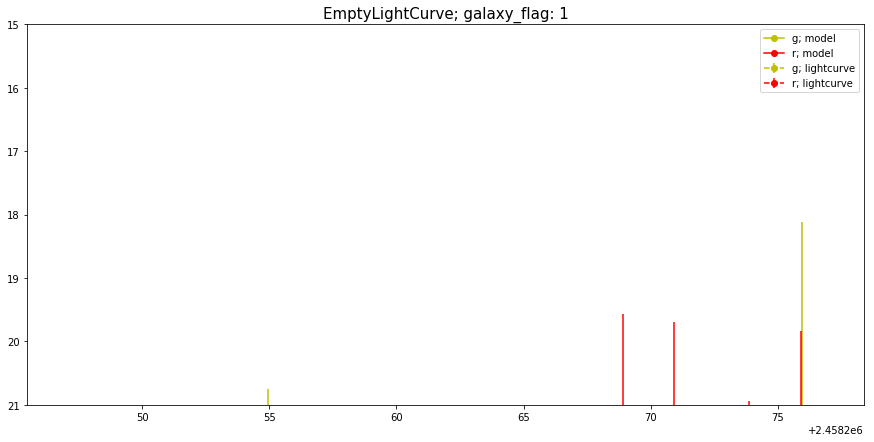

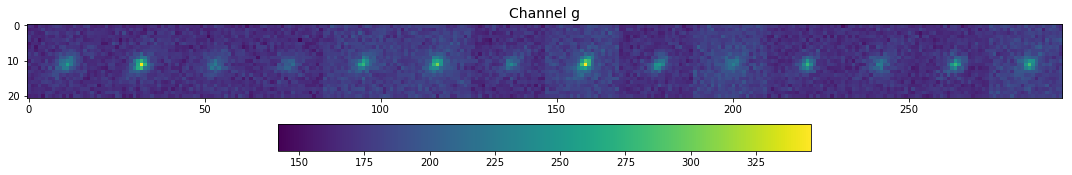

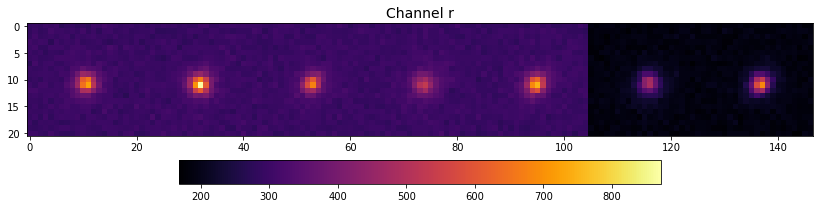


Field34
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
field images g: (60, 21, 21, 15) r: (60, 21, 21, 10)
lcs g: (60, 15) r: (60, 10)
obs days <HDF5 dataset "g": shape (15,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 15), type "<f8">
obs days <HDF5 dataset "r": shape (10,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 10), type "<f8">
Field34[54]
[26.36050701 26.40137064 26.36329603 26.33325553 26.32304013 26.35204947
 26.34465313 26.32729292 26.34061539 26.34998119 26.31532168 26.2864188
 26.32227504 26.27787149 26.34510088]
[26.41469705 26.21442127 26.23528099 26.29917967 26.35924125 26.20344496
 26.29286861 26.26007438 26.27268791 26.41502941]


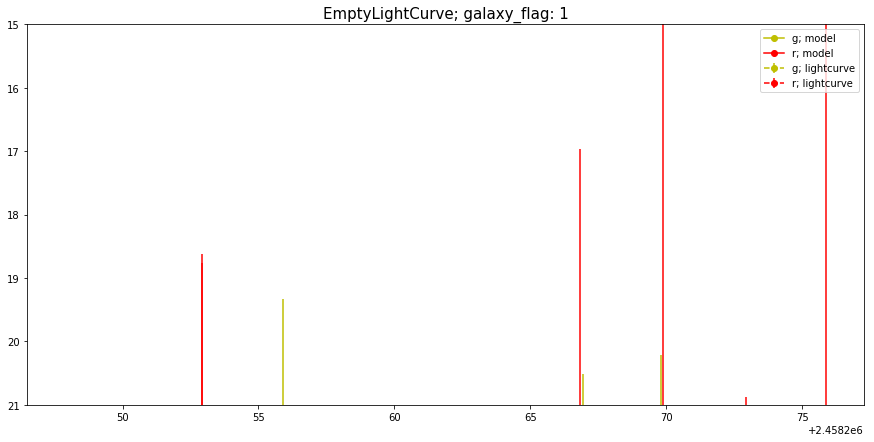

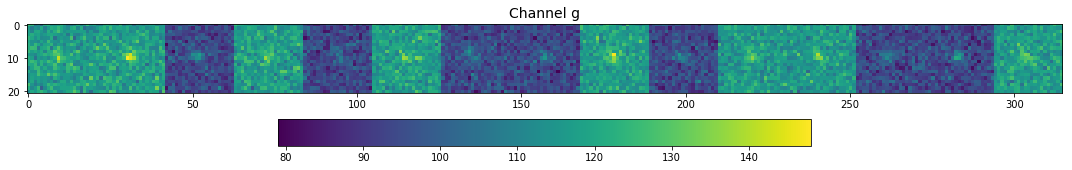

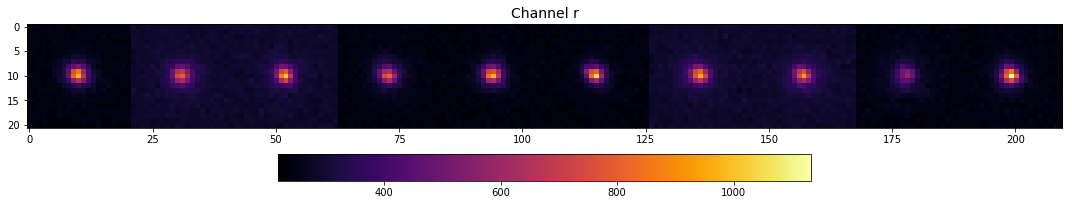


Field35
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
field images g: (60, 21, 21, 24) r: (60, 21, 21, 1)
lcs g: (60, 24) r: (60, 1)
obs days <HDF5 dataset "g": shape (24,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 24), type "<f8">
obs days <HDF5 dataset "r": shape (1,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 1), type "<f8">
Field35[40]
[26.68938732 26.52690578 26.48582435 26.29025245 26.29838395 23.
 26.21140969 26.3260293  26.10973465 26.36284435 26.37298286 26.44999683
 26.04732919 26.25228453 26.32262433 26.39099061 26.46643519 26.43492973
 26.43313289 26.47676325 26.47602558 26.41819263 26.48050725 26.45797384]
[26.36548877]


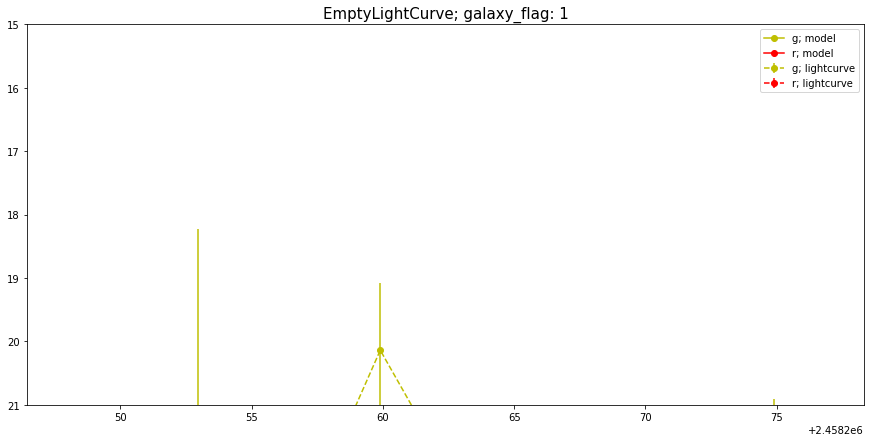

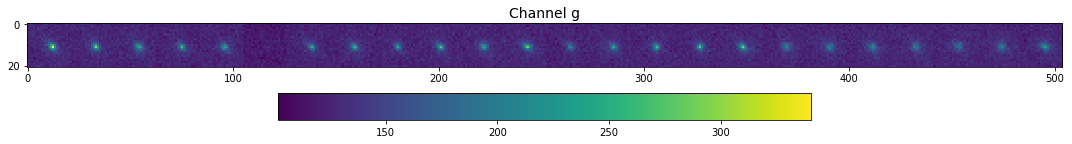

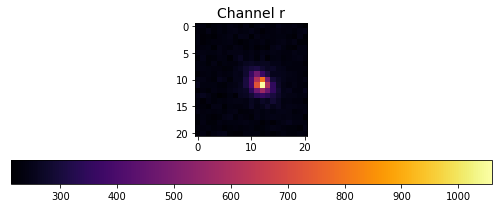


Field36
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
field images g: (60, 21, 21, 14) r: (60, 21, 21, 12)
lcs g: (60, 14) r: (60, 12)
obs days <HDF5 dataset "g": shape (14,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 14), type "<f8">
obs days <HDF5 dataset "r": shape (12,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 12), type "<f8">
Field36[19]
[26.35698378 26.42200899 26.32357466 26.42324555 26.34305024 26.15480924
 26.15538681 26.3234098  26.32259834 26.32173443 26.41452336 26.31656921
 26.51518345 26.16477263]
[26.57807791 26.27199304 26.46810126 26.23283422 26.4744668  26.32500422
 26.25768721 26.27502489 26.41624284 26.37192225 26.36899614 26.30203903]


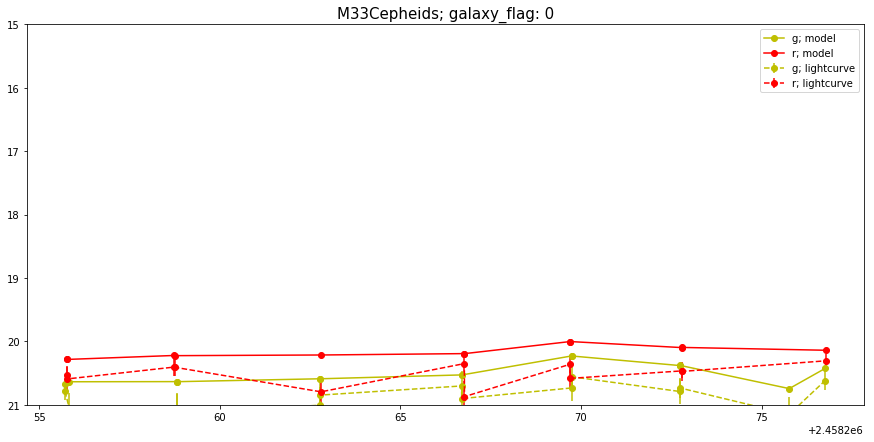

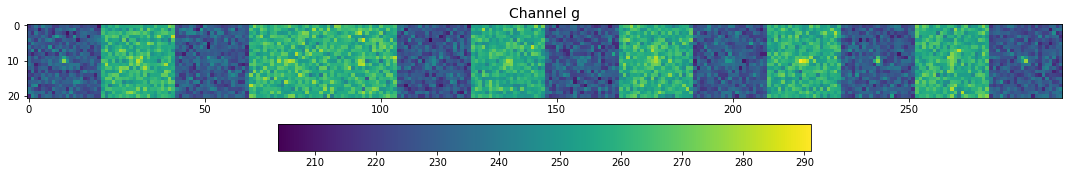

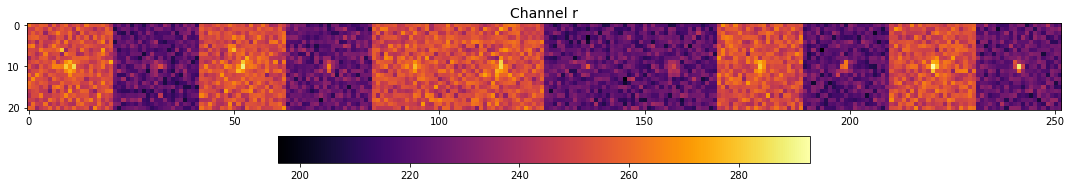


Field38
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
field images g: (60, 21, 21, 14) r: (60, 21, 21, 11)
lcs g: (60, 14) r: (60, 11)
obs days <HDF5 dataset "g": shape (14,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 14), type "<f8">
obs days <HDF5 dataset "r": shape (11,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 11), type "<f8">
Field38[40]
[26.38124883 26.34418058 26.35968697 26.37064731 26.31222785 26.33681333
 26.34834254 26.37970221 26.40703857 26.33624279 26.23712921 26.52729595
 26.41175914 26.37368226]
[26.32635486 26.32438695 26.34417093 26.1618644  26.30311561 26.19662821
 26.27098489 26.31268823 26.37081265 26.34335124 26.31154275]


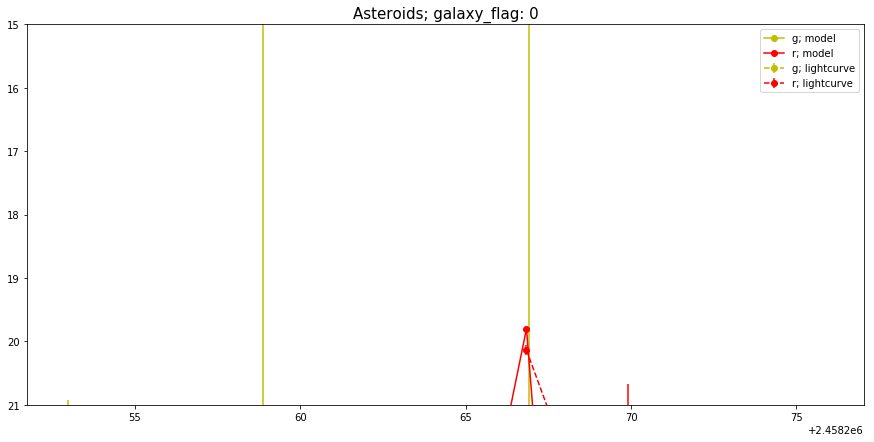

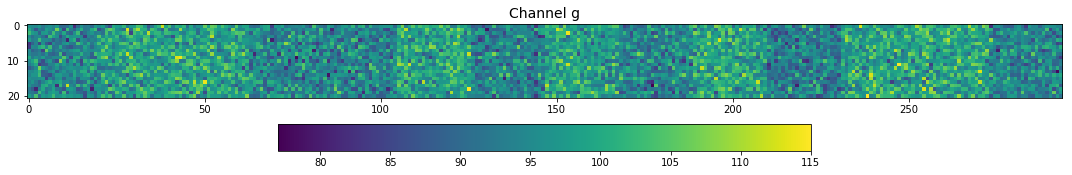

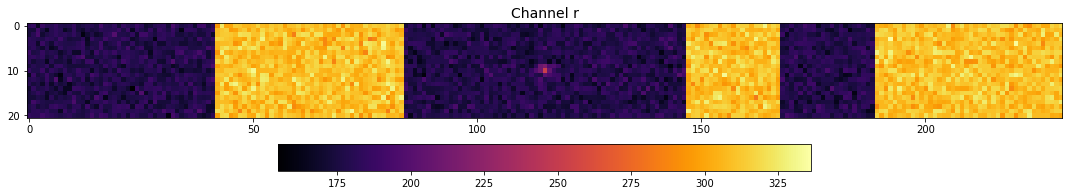


Field39
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
field images g: (60, 21, 21, 27) r: (60, 21, 21, 16)
lcs g: (60, 27) r: (60, 16)
obs days <HDF5 dataset "g": shape (27,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 27), type "<f8">
obs days <HDF5 dataset "r": shape (16,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 16), type "<f8">
Field39[18]
[26.4710027  26.27371705 26.08570504 26.40298498 26.00048745 25.81720698
 26.24875557 25.8526808  26.10885775 25.82558322 26.23771608 26.63566828
 26.14095259 25.8124063  26.54019547 26.15755403 26.4939301  26.19825554
 26.38140345 26.32301152 26.28574097 26.29461598 26.29003608 26.37698627
 26.47908413 26.27694499 26.29709172]
[26.28406024 26.30438781 26.30177069 26.29000235 26.28714633 26.29832244
 26.28493738 26.32205462 26.29446721 26.28839517 26.28479099 26.29478669
 26.2913863

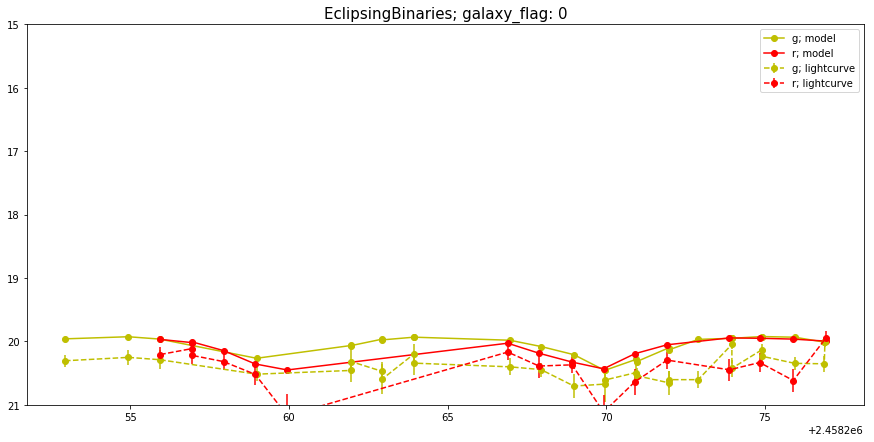

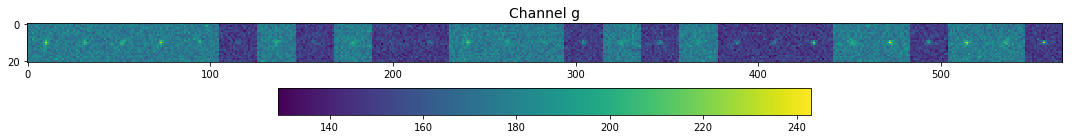

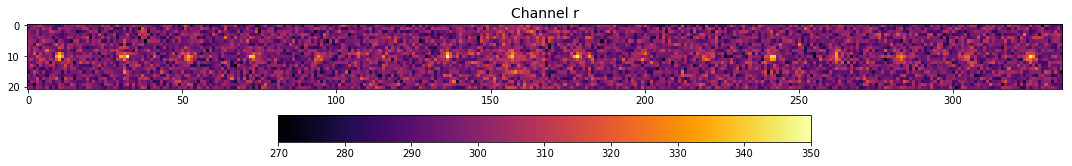


Field40
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
field images g: (60, 21, 21, 15) r: (60, 21, 21, 8)
lcs g: (60, 15) r: (60, 8)
obs days <HDF5 dataset "g": shape (15,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 15), type "<f8">
obs days <HDF5 dataset "r": shape (8,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 8), type "<f8">
Field40[36]
[26.51836729 26.48773611 26.1280216  26.35634017 26.08822393 26.31106448
 26.24169886 26.31717205 26.43558347 26.08999443 26.25742698 26.39932621
 26.61739242 26.33131897 26.4911257 ]
[26.22537243 26.31482911 26.31866217 26.30877769 26.3310554  26.33993709
 26.36932194 26.33492279]


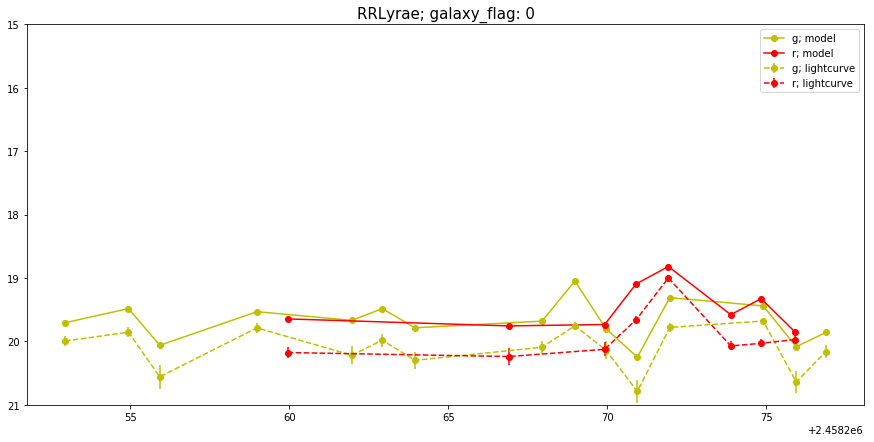

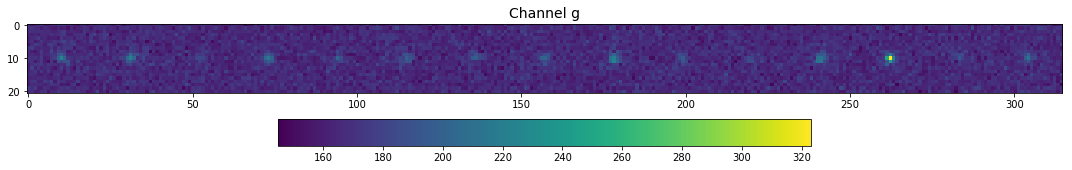

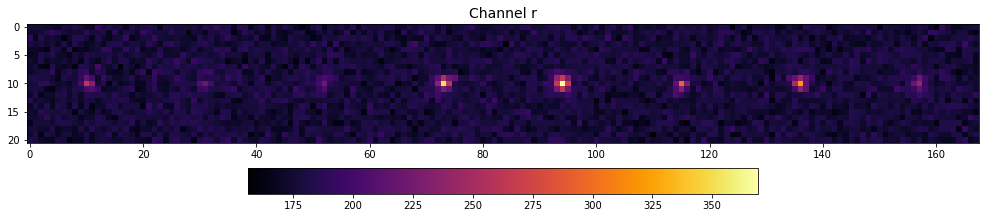


Field41
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
field images g: (60, 21, 21, 3) r: (60, 21, 21, 23)
lcs g: (60, 3) r: (60, 23)
obs days <HDF5 dataset "g": shape (3,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 3), type "<f8">
obs days <HDF5 dataset "r": shape (23,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 23), type "<f8">
Field41[12]
[26.32108903 26.16319942 26.43606198]
[26.39669096 26.35220253 26.38502657 26.36319757 26.32094908 26.28416014
 26.2853806  26.26350272 26.26611149 26.31471252 26.3351686  26.29773831
 26.22031474 26.31369841 26.31446779 26.37091863 26.25709343 26.39732182
 26.39493239 26.48451161 26.45066547 26.40732956 26.29983473]


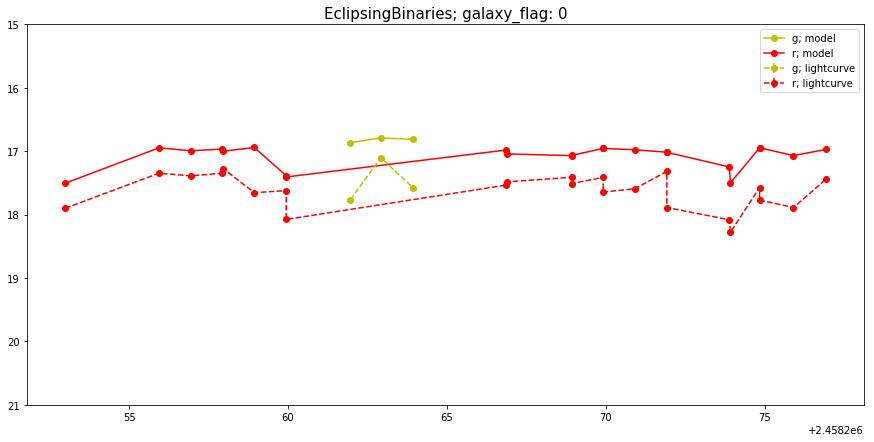

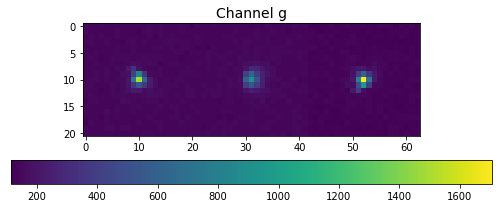

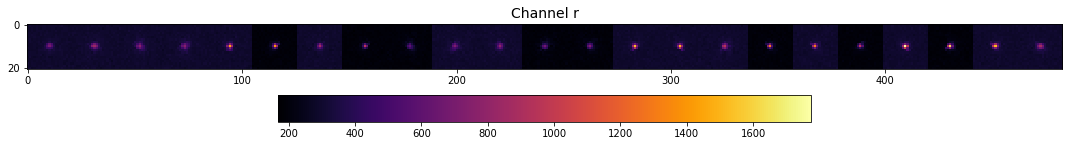


Field43
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
field images g: (60, 21, 21, 11) r: (60, 21, 21, 15)
lcs g: (60, 11) r: (60, 15)
obs days <HDF5 dataset "g": shape (11,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 11), type "<f8">
obs days <HDF5 dataset "r": shape (15,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 15), type "<f8">
Field43[24]
[26.15128672 26.29563808 26.39971447 26.45845485 26.36577725 26.23533499
 26.45017672 26.36781287 26.32366323 26.36206245 26.34620321]
[26.34624648 27.08274817 26.28214955 26.26859796 26.63679826 26.22067094
 26.37086654 25.87204814 26.31786156 26.3078661  26.30191278 26.29799509
 26.30205846 26.29790878 26.30228639]


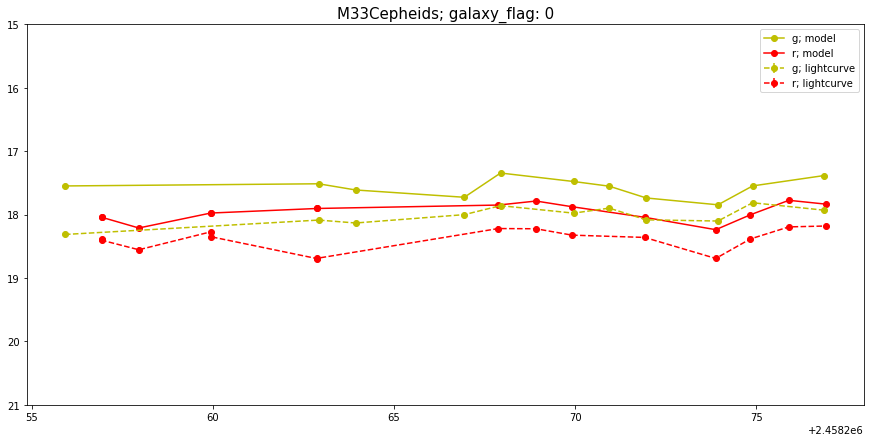

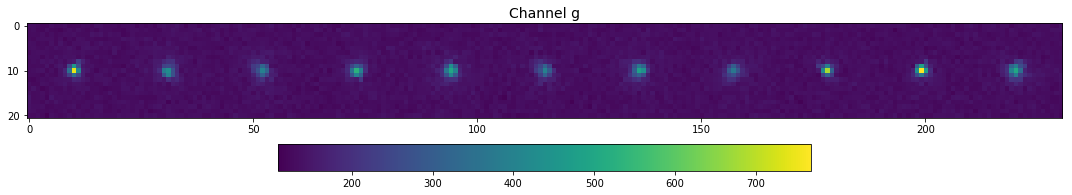

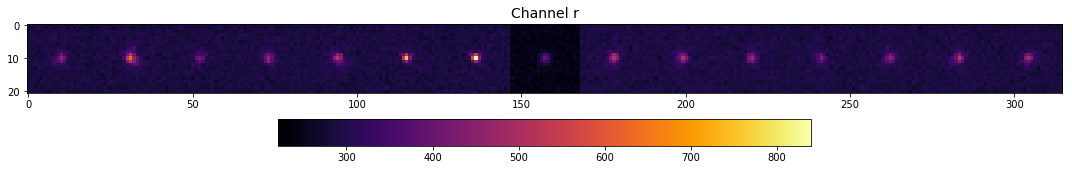


Field44
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
field images g: (60, 21, 21, 12) r: (60, 21, 21, 10)
lcs g: (60, 12) r: (60, 10)
obs days <HDF5 dataset "g": shape (12,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 12), type "<f8">
obs days <HDF5 dataset "r": shape (10,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 10), type "<f8">
Field44[23]
[26.34624124 26.27683532 26.38099992 26.36187053 26.35567057 26.35963655
 26.34846711 26.35360479 26.33365381 26.34846115 26.34562945 26.36326468]
[26.30542731 26.2527287  26.29619551 26.29511595 26.29751968 26.30185986
 26.29952192 26.29923272 26.29465723 26.29835796]


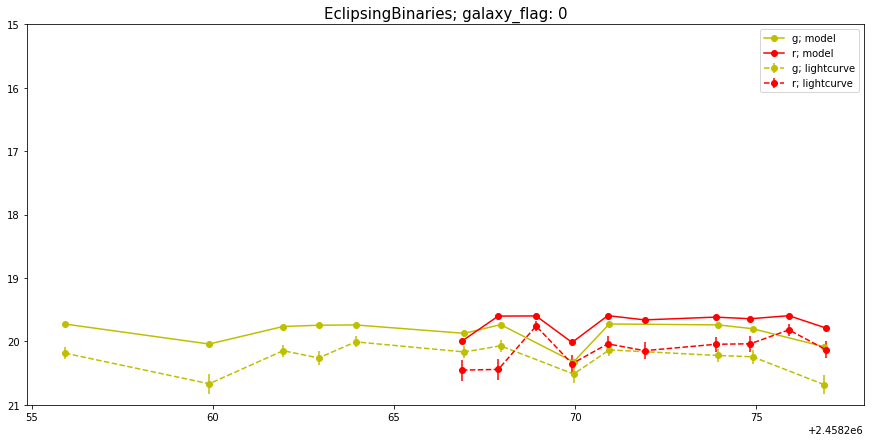

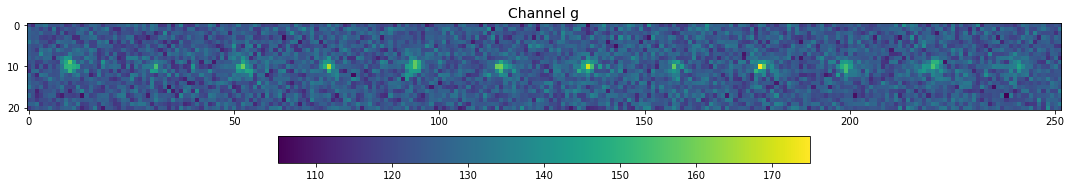

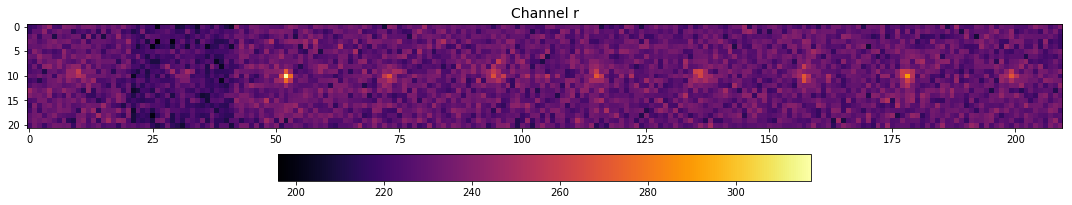

In [9]:
bands = ["g", "r"]
n_per_field = 3
for field in fields:
    print('\n%s' % (field))
    #if field in ['Field01', 'Field03', 'Field04', 'Field08', 'Field12']:
    #    continue
    field_data = f[field]
    print(list(field_data))
    field_images = field_data["images"]
    print("field images g:", field_images["g"].shape, "r:", field_images["r"].shape)
    field_lc = field_data["lightcurves"]
    print("lcs g:", field_lc["g"].shape, "r:", field_lc["r"].shape)
    days = field_data["obs_cond"]["obs_day"]
    #print(field_data["obs_cond"]["sky_brightness"]["r"][:])
    
    for band in bands:
        print('obs days %s' % str(days[band]))
        print('estimated_counts %s' % str(field_data['estimated_counts'][band]))
    if  days[bands[1]].shape[0]!=field_data['estimated_counts'][bands[1]].shape[1]:
        continue
    idx = plot_underliying_and_lc_model(f, field=field)
    lc_type = field_data["lc_type"][idx]
    
    """
    plt.figure(figsize=(15, 7))
    for band in bands:
        plt.plot(days[band], field_lc[band][0, ...], "o-", label=band)
    galaxy_flag = field_data["galaxy_flag"][0]
    plt.title(lc_type+" galaxy_flag", fontsize=15)
    plt.ylim([21, 15])
    plt.legend()
    plt.show()
    """
    for band in bands:
        n_images = field_lc[band].shape[1]
        plt.figure(figsize=(15,3))#3*n_images,3))
        empty_image = np.zeros((21, 21*n_images,))
        for i in range(n_images):
            empty_image[:, i*21:(i+1)*21] = field_images[band][idx, :, :, i]
        if band == "g":
            c_map = "viridis"
        else:
            c_map = "inferno"
        plt.imshow(empty_image, cmap=c_map)
        plt.title('Channel %s' % band, fontsize=14)#np.amin(empty_image))
        plt.colorbar(orientation="horizontal")
        plt.tight_layout()
        plt.show()